# Incorporating Context into Language Encoding Models for fMRI
**Project by Team - Synaptic**
- Pratham Gupta
- Amal Sunny
- Aayush Bhandari

Language encoding models help explain language processing in the human brain by learning functions that predict brain responses from the language stimuli that elicited them. Current word embedding-based approaches treat each stimulus word independently and thus ignore the influence of context on language understanding. This work instead builds encoding models using rich contextual representations derived from an LSTM language model ultimately aiming to show a significant improvement in encoding performance relative to state-of-the-art embeddings in nearly every brain area. 

#### Acknowledgements
This fMRI data used in our project was collected by Alex Huth and Wendy de Heer at the University of California, Berkeley. All work was supervised by professors Jack Gallant and Frederic Theunissen of the UC Berkeley Psychology Department. Visualization is done using [pycortex](http://pycortex.org).

## The experiment
In this experiment a subject underwent fMRI scanning while they listened to roughly 2 hours of natural narrative speech stimuli. These stimuli were 10-15 minute complete stories drawn from *The Moth Radio Hour*, a radio program where storytellers tell true, autobiographical stories in front of a live audience.

In [311]:
%config InlineBackend.figure_format = 'retina'

In [4]:
from matplotlib.pyplot import figure, cm
import numpy as np
import logging
logging.basicConfig(level=logging.DEBUG)
from tqdm import tqdm
from pprint import pprint

## The semantic model: English1000
Here we load a precomputed vector-space semantic model. This semantic model will transform any word (well, any word it knows about) into a 985-dimensional vector. This 985-dimensional semantic space has the nice property that words that are close together tend to have similar meanings.

The semantic model was constructed using a decently large corpus of text (a couple billion words, comprising the stories used as stimuli here, 604 popular books, 2,405,569 wikipedia pages, and 36,333,459 user comments scraped from reddit.com) and a lexicon of roughly 10,000 words. We selected 985 "basis words" from the Wikipedia "List of 1000 basic words" (contrary to the title, this lost does not actually contain 1000 words, but this is where the title of the model comes from). These are common words that span many topics.

This model has properties that are very similar to Mikolov's [word2vec model](https://code.google.com/p/word2vec/).

In [314]:
# Load semantic model
# The SemanticModel class makes it easy to deal with vector-space semantic models.

from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("data/english1000sm.hf5")

DEBUG:SemanticModel:Loading file: data/english1000sm.hf5
DEBUG:SemanticModel:Done loading file..


In [315]:
# We can get the vector for a word by indexing the model with that word
# For example, the vector for "finger":
print(eng1000["finger"])

[-3.01957543e-02 -1.58815208e-01  3.72586468e-01  6.31520216e-01
 -5.41207327e-01 -1.47432759e+00 -1.05915070e+00 -4.16644800e-01
  1.20502323e-01 -5.15060363e-01  1.23904878e-01 -9.33992565e-01
 -1.05883262e-01 -5.79853435e-01  2.94983034e-02 -2.43542920e-01
 -5.92298265e-01  6.90182885e-02 -5.13458809e-01  1.53945791e-01
 -2.98635717e-01 -1.76474347e-01 -5.17992699e-01 -2.67308837e-01
  5.05877087e-01 -9.80404899e-02 -4.44428154e-02 -3.05776285e-01
  2.97729455e-01  2.37905694e-01 -1.88648910e-01 -3.17506290e-01
 -5.33254593e-01 -7.07116002e-01  2.54096127e+00 -1.84512793e+00
  6.68122823e-01 -3.54202630e-01 -6.79908010e-01 -5.19517465e-01
  2.52528273e-01  1.00967376e-01 -7.86818600e-01  1.75987727e-01
 -2.20915266e+00  2.79098918e-01  6.21732275e-01  6.84270165e-01
  2.10828246e-01  9.80781382e-01  1.50115083e+00 -1.05500410e+00
  3.13293716e-01  5.32585620e-01 -2.91568208e-01 -4.38885716e-01
  1.10569814e+00 -1.87596079e-01  4.91572934e-01  6.95940502e-02
  6.46628909e-01 -1.92923

### Visualizing a word
First let's plot the length 985 vector for one word to see what it looks like.

Text(0, 0.5, 'Feature value')

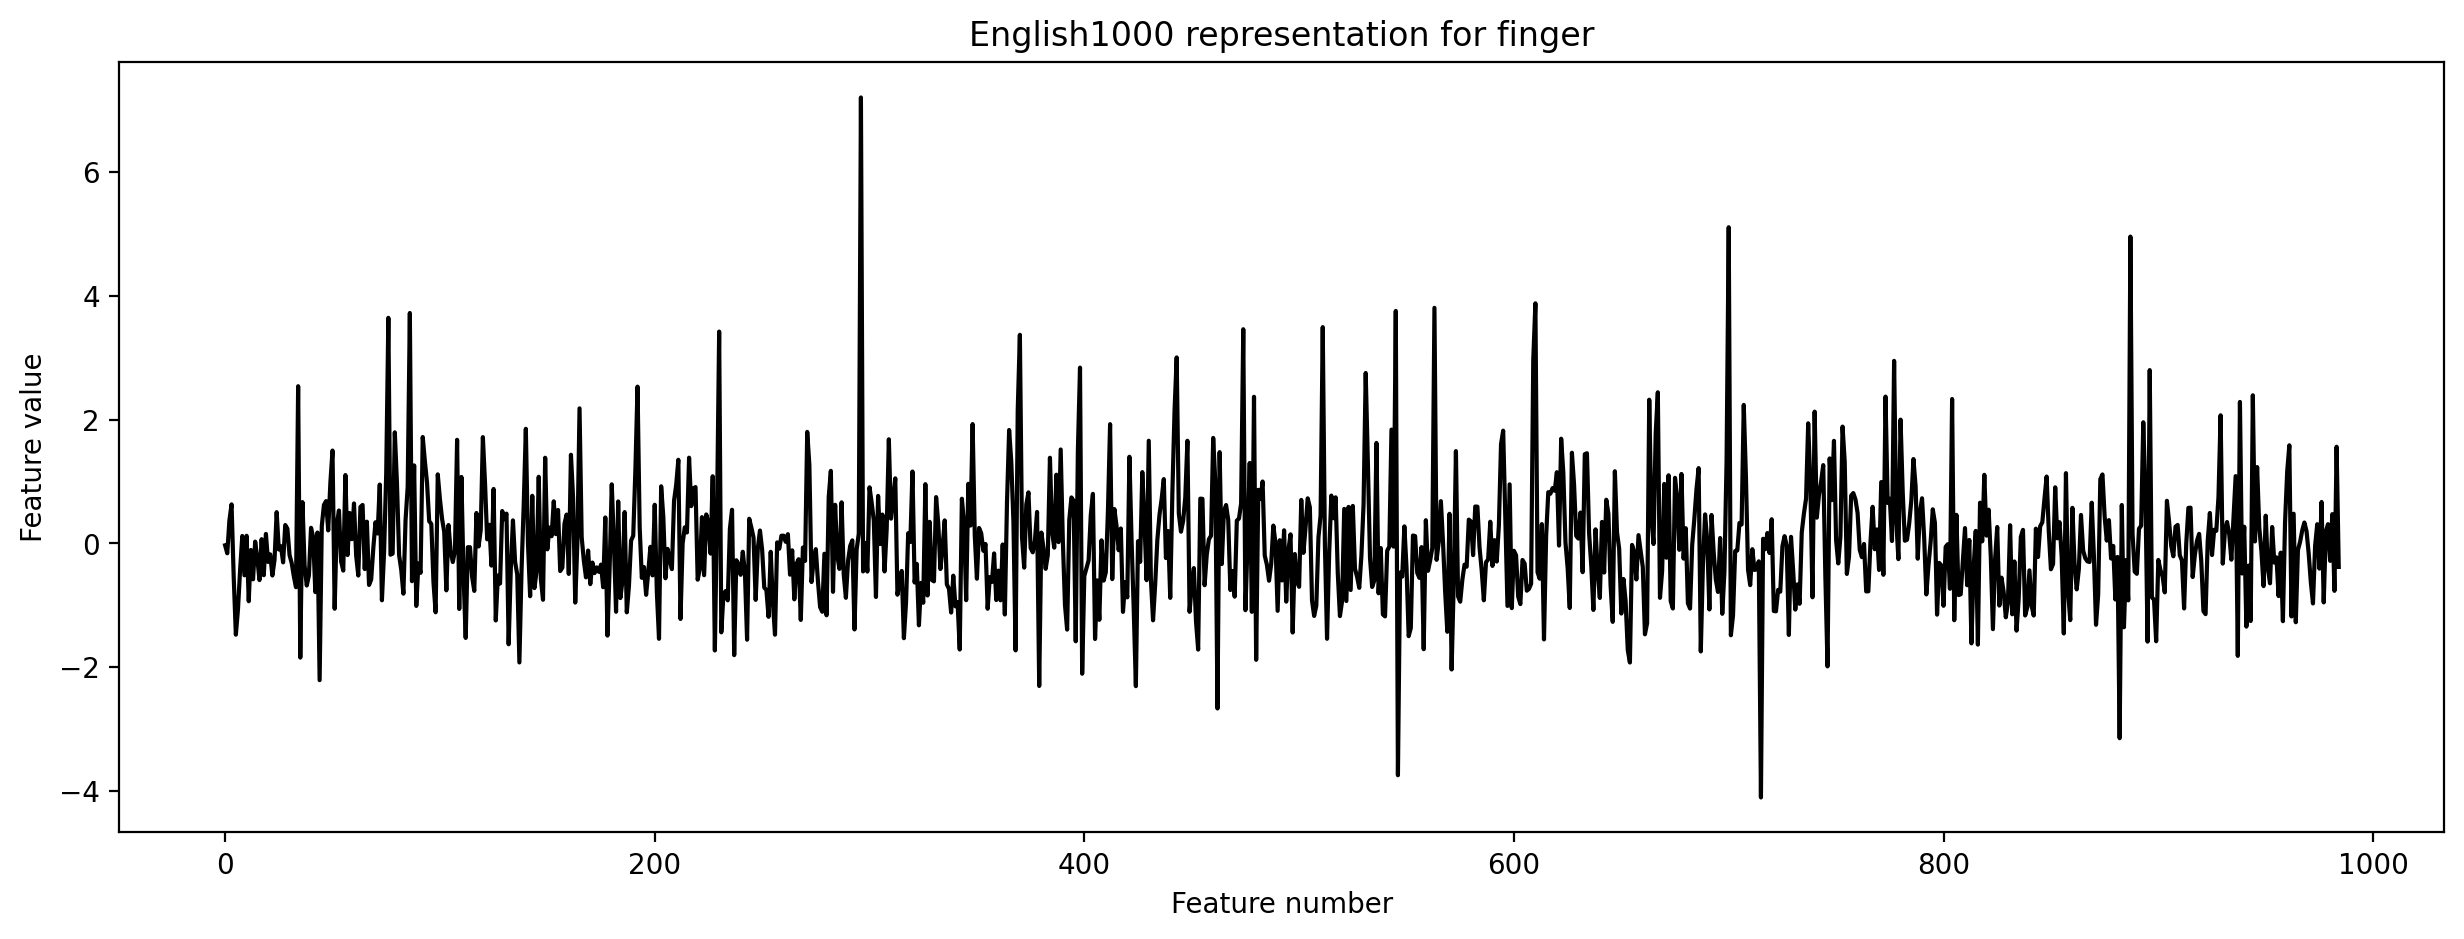

In [316]:
plot_word = "finger"

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(eng1000[plot_word], 'k')
ax.axis("tight")
ax.set_title("English1000 representation for %s" % plot_word)
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")

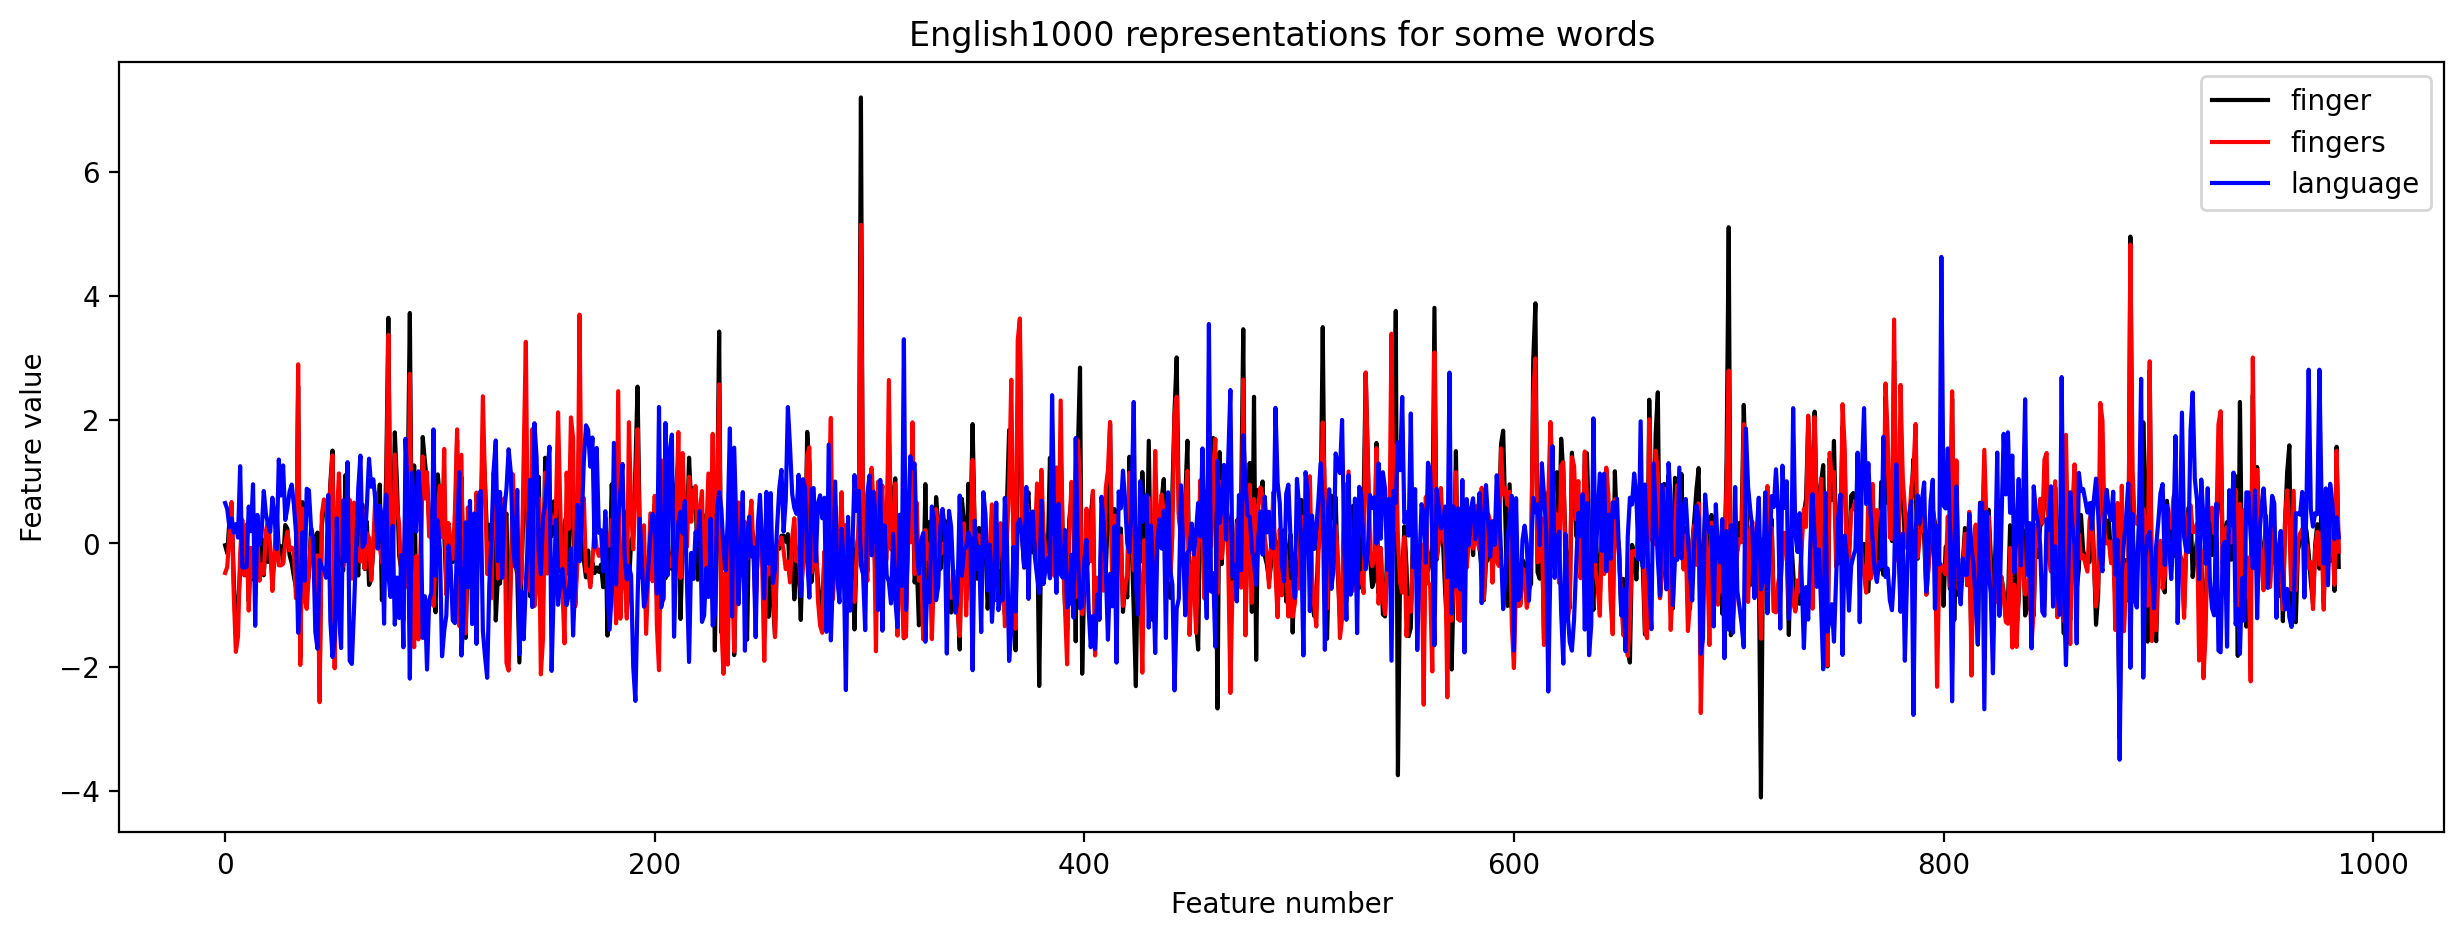

In [317]:
plot_words = ["finger", "fingers", "language"]
colors = ["k", "r", "b"]

f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
wordlines = []

for word, color in zip(plot_words, colors):
    wordlines.append(ax.plot(eng1000[word], color)[0])

ax.axis("tight")
ax.set_title("English1000 representations for some words")
ax.set_xlabel("Feature number")
ax.set_ylabel("Feature value")
ax.legend(wordlines, plot_words)

## The stimuli: Moth stories
We load  the stimuli as aligned transcripts. These were generated using the UPenn forced aligner (P2FA), which figures out when each word was spoken given the transcript and the audio. The transcripts are stored in TextGrid format (native to Praat), which can be loaded directly into Python using some code from the natural language toolkit (NLTK).

The TextGrids for the stories are loaded, as well as 'TRfiles', which specify the time points relative to story onset when the fMRI data was collected (roughly every 2 seconds).

We combine TextGrids and TRfiles together into a representation called a *'DataSequence'*.

In [321]:
# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy']


# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

In [322]:
pprint(trfiles)

{'alternateithicatom': [<stimulus_utils.TRFile object at 0x000001B470807010>],
 'avatar': [<stimulus_utils.TRFile object at 0x000001B470806F80>],
 'howtodraw': [<stimulus_utils.TRFile object at 0x000001B45F841D50>],
 'legacy': [<stimulus_utils.TRFile object at 0x000001B470806AA0>],
 'life': [<stimulus_utils.TRFile object at 0x000001B4707C3700>],
 'myfirstdaywiththeyankees': [<stimulus_utils.TRFile object at 0x000001B4707C3C40>],
 'naked': [<stimulus_utils.TRFile object at 0x000001B4707C3EE0>],
 'odetostepfather': [<stimulus_utils.TRFile object at 0x000001B4707C2B30>],
 'souls': [<stimulus_utils.TRFile object at 0x000001B4707C3E80>],
 'undertheinfluence': [<stimulus_utils.TRFile object at 0x000001B4707C3790>],
 'wheretheressmoke': [<stimulus_utils.TRFile object at 0x000001B475946080>]}


In [326]:
wordlist = {}
for storyname, wordseq in wordseqs.items():
    wordlist[storyname] = list(wordseq.data)

## Bert

In [333]:
!pip install transformers

In [334]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import KFold
from scipy.spatial.distance import cosine
from transformers import AutoTokenizer, AutoModel , BertTokenizer, BertModel
import torch 
# import gensim.downloader as gsd
from math import comb

In [335]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a

In [336]:
CONTEXTS = range(1, 21)

In [337]:
import pickle
from pprint import pprint

In [338]:
for story in allstories:
    # Load existing dictionary if file exists, otherwise create new dictionary
    try:
        with open('contexts_12.p', 'rb') as f:
            CONTEXT_DICT = dict(pickle.load(f))
    except FileNotFoundError:
        CONTEXT_DICT = {}
    pprint(CONTEXT_DICT.keys())
    if story not in CONTEXT_DICT.keys() :
        CONTEXT_DICT[story] = np.zeros((20, len(wordlist[story]), 768))
        print(story)
    else:
      continue
    
    for context in CONTEXTS:
        print(context, end=' ')
        for i in range(1, len(wordlist[story])+1):
            context_words = wordlist[story][i-context if (i-context)>0 else 0:i]
            context_string = ' '.join(context_words)
            lay12_embeddings = []

            s= bert_tokenizer.encode(context_string, add_special_tokens=True) 
            input_id = torch.tensor(s).unsqueeze(0)
            with torch.no_grad():
                outputs = bert_model(input_id)
                hidden_states = outputs[2][1:]
            #put the activations from the final layer into the dictionary
            CONTEXT_DICT[story][context-1, i-1, :] = hidden_states[11][:,-2,:].numpy() # l

    # Append to the existing file
    with open('contexts_12.p', 'wb') as f:
        pickle.dump(CONTEXT_DICT, f)

dict_keys([])
alternateithicatom
1 

KeyboardInterrupt: 

In [339]:
with open('embeddings/context/contexts_12.p', 'rb') as f:
    CONTEXT_DICT = dict(pickle.load(f))

In [340]:
pprint(CONTEXT_DICT)

{'alternateithicatom': array([[[ 1.14757109e+00, -3.70295107e-01,  5.69489896e-01, ...,
         -1.02031142e-01,  7.09185243e-01, -7.50185922e-02],
        [-9.17520225e-01, -6.76067114e-01, -4.05717075e-01, ...,
          2.91149825e-01,  1.27978399e-01,  2.23105624e-01],
        [-5.12827158e-01, -1.04218945e-02,  9.71426442e-02, ...,
         -2.73162127e-01,  4.19142276e-01, -6.69282004e-02],
        ...,
        [-4.92248714e-01, -6.78673446e-01,  2.10898072e-02, ...,
          2.24829420e-01,  6.45701051e-01, -2.83071846e-01],
        [ 2.32412502e-01,  4.03281680e-04,  9.93222147e-02, ...,
          2.92604655e-01,  1.15054622e-01, -6.65035009e-01],
        [-4.04372364e-02, -2.93849885e-01, -2.27277335e-02, ...,
         -3.01927716e-01,  3.44806850e-01, -7.32067466e-01]],

       [[ 1.14757109e+00, -3.70295107e-01,  5.69489896e-01, ...,
         -1.02031142e-01,  7.09185243e-01, -7.50185922e-02],
        [-1.64575636e-01, -3.50740105e-01, -2.86600679e-01, ...,
          7.338

In [341]:
help(dict)

Help on class dict in module builtins:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |  

## Get embeddings with swapped contexts

In [ ]:
#swap contexts for same words within a story
SWAPPED_CONTEXT_DICT = {}
for story in tqdm(allstories):
    SWAPPED_CONTEXT_DICT[story] = np.zeros((20, len(wordlist[story]), 768))
    for context in CONTEXTS:
        for i in range(1, len(wordlist[story])+1):
            SWAPPED_CONTEXT_DICT[story][context-1, i-1, :] = CONTEXT_DICT[story][context-1, i-1, :]
        for i in range(0, len(wordlist[story])):
            for j in range(i+1, len(wordlist[story])):
                if wordlist[story][i] == wordlist[story][j]:
                    SWAPPED_CONTEXT_DICT[story][context-1, i, :] = CONTEXT_DICT[story][context-1, j, :]
                    temp = SWAPPED_CONTEXT_DICT[story][context-1, i, :]
                    SWAPPED_CONTEXT_DICT[story][context-1, j, :] = temp

In [ ]:
with open('swapped_contexts_12.p', 'wb') as f:
    pickle.dump(SWAPPED_CONTEXT_DICT, f)

## Projecting the stimuli into the semantic space
The next step in this analysis is that we need to project each word in the stimulus into the English1000 semantic feature space that we loaded above. `make_semantic_model`  simply takes the word DataSequence and the semantic model, and outputs a new DataSequence where each word is replaced by a 985-dimensional vector.

In [351]:
# Project stimuli
from dsutils import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_model(wordseqs[story], eng1000)

In [352]:
CONTEXTsemanticseqs = dict()
for story in allstories:
    CONTEXTsemanticseqs[story] = ['']*20
    for context in CONTEXTS:
        CONTEXTsemanticseqs[story][context-1] = make_semantic_model(wordseqs[story], eng1000)
        CONTEXTsemanticseqs[story][context-1].data = CONTEXT_DICT[story][context-1]

In [354]:
print(CONTEXTsemanticseqs['naked'][0].data.shape)

(3218, 768)


In [355]:
# take a look at the projected stimuli
naked_proj = semanticseqs["naked"]

print (naked_proj.data.shape) # prints the shape of 'data' as (rows, columns)
print (naked_proj.data[:10]) # print the first 10 rows (this will be truncated)

(3218, 985)
[[-0.48074415  0.10393176 -0.45596143 ... -0.03175243 -0.62248756
  -0.32170921]
 [ 0.09911849  0.06500191 -0.78847992 ...  1.95413789 -0.94043714
  -1.0863888 ]
 [-0.73058513 -0.37099858 -0.59858174 ... -0.30655477 -0.30774183
  -0.66815734]
 ...
 [ 0.59646679  0.31843488  0.78981277 ...  0.21670864 -1.09263289
  -1.26290446]
 [-0.61541241 -1.1005762  -0.33248156 ...  0.23637707 -1.5470721
  -0.6521566 ]
 [ 0.3866531  -0.05810349 -0.63087673 ...  0.43836955 -1.03314247
  -0.57172974]]


### Downsample the projected stimuli
In order to build a model, we need to downsample the semantic representations of the stimuli to the same temporal scale as the fMRI responses that we will be modeling. The DataSequence provides a method that does this, called `chunksums`.

Downsampling is accomplished here using a 3-lobe Lanczos filter (see [here](http://en.wikipedia.org/wiki/Lanczos_window).

In [356]:
# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


In [357]:
downsampled_semanticseqs['avatar'].shape

(382, 985)

In [360]:
# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_CONTEXTS = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_CONTEXTS[story] = []
    for context in CONTEXTS:
        downsampled_CONTEXTS[story].append(CONTEXTsemanticseqs[story][context-1].chunksums(interptype, window=window))


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobe

In [362]:
print(downsampled_semanticseqs['naked'].shape, downsampled_CONTEXTS['naked'][0].shape)

(437, 985) (437, 768)


### Visualizing the downsampling
We plot the value of one semantic feature (feature 2, which is actually the third feature: zero-based indexing) for each word, and also the downsampled vector.

#### 1. Baseline embeddings:

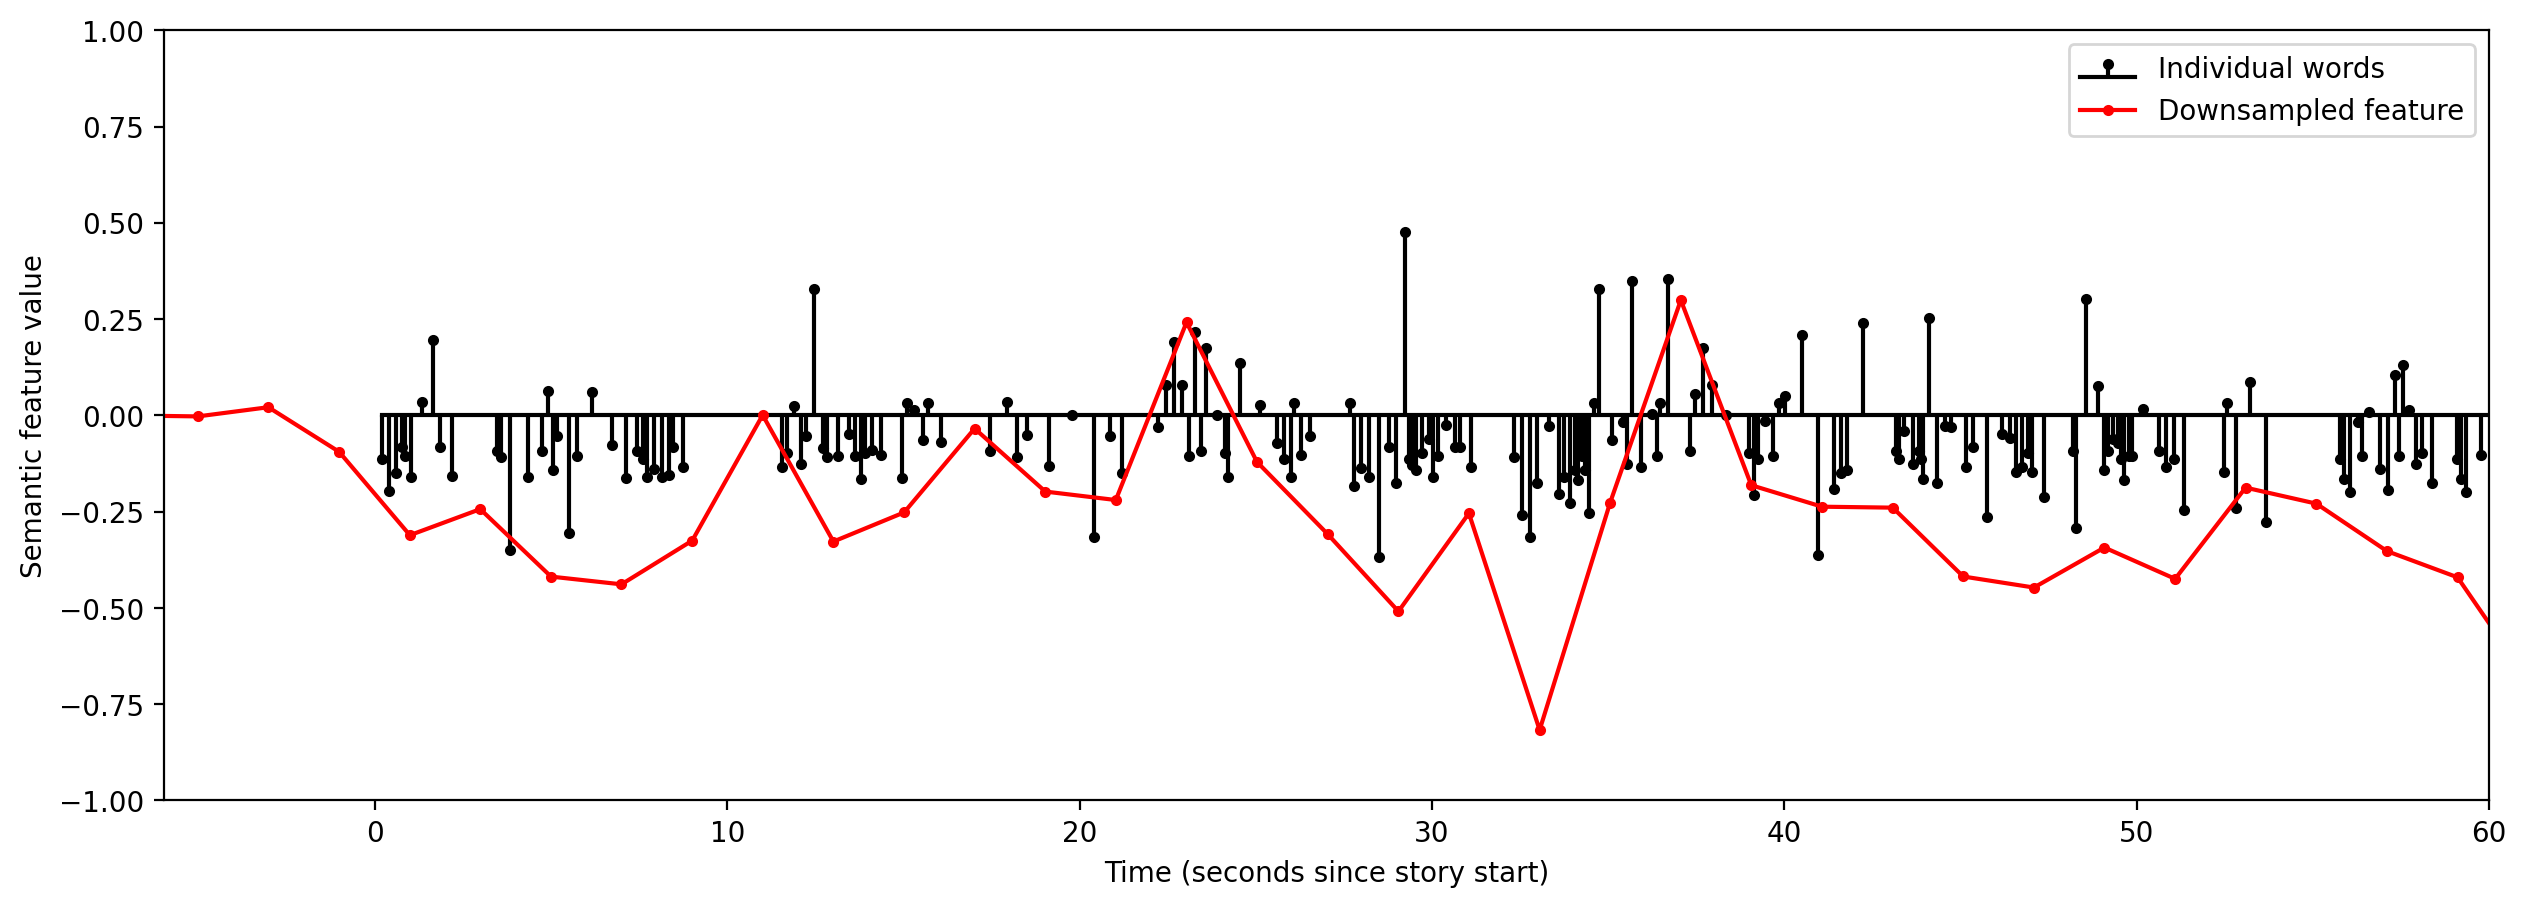

In [363]:
# Plot the result
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

f = figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times, 
                    s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_sem.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

#### 2. Contexualized embeddings:

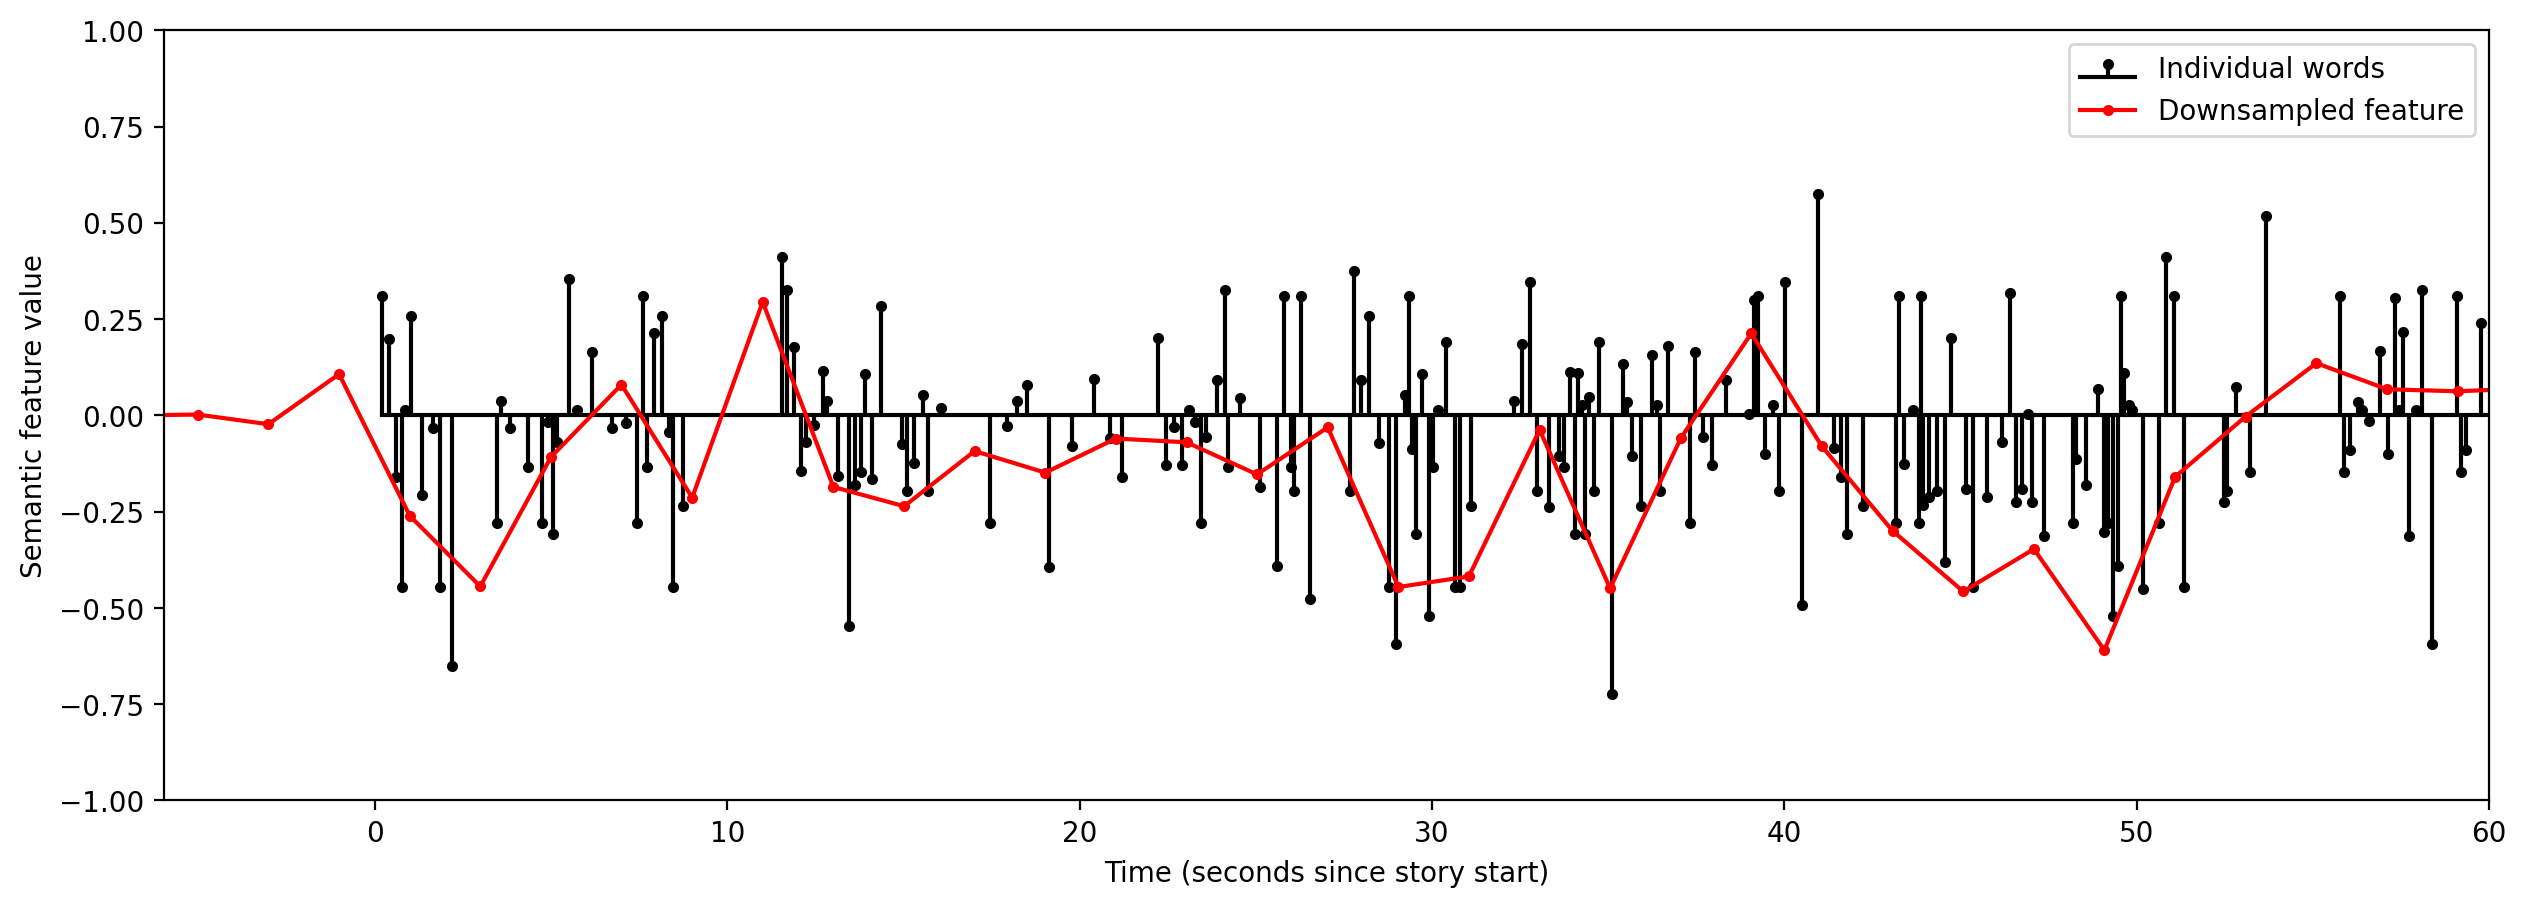

In [364]:
# Plot the result
s_words = wordseqs["naked"]
s_sem = CONTEXTsemanticseqs["naked"][0]
s_semdown = downsampled_CONTEXTS["naked"][0]

f = figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times, s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_sem.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

### Concatenating features across stories
Next we combine together all the features from all the stories into one big matrix. Within this operation, we're also going to [z-score](http://en.wikipedia.org/wiki/Z-score) each feature within each story. This operation subtracts off the mean and then divides by the standard deviation. 

The features for each story are also trimmed a bit (the variable `trim` determines how many time points are removed from the beginning and end of each story). The fMRI responses at the beginnings and ends of the stories are often noisier than at other.

The combined features are stored in big matrices called `Rstim` (with the training, or Regression stimuli) and `Pstim` (with the test, or Prediction stimuli).

In [365]:
# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])

In [366]:
CONTEXT_Rstim = []
CONTEXT_Pstim = []

for context in CONTEXTS:
    CONTEXT_Rstim.append(np.vstack([zscore(downsampled_CONTEXTS[story][context-1][5+trim:-trim]) for story in Rstories]))
    CONTEXT_Pstim.append(np.vstack([zscore(downsampled_CONTEXTS[story][context-1][5+trim:-trim]) for story in Pstories]))

In [367]:
storylens = [len(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories]
print(storylens)

print(np.cumsum(storylens))

[343, 367, 354, 400, 430, 358, 422, 404, 355, 304]
[ 343  710 1064 1464 1894 2252 2674 3078 3433 3737]


In [368]:
# Print the sizes of these matrices
print ("Rstim shape: ", Rstim.shape)
print ("Pstim shape: ", Pstim.shape)

Rstim shape:  (3737, 985)
Pstim shape:  (291, 985)


In [369]:
print(CONTEXT_Rstim[0].shape)

(3737, 768)


### Visualizing the combined stimuli

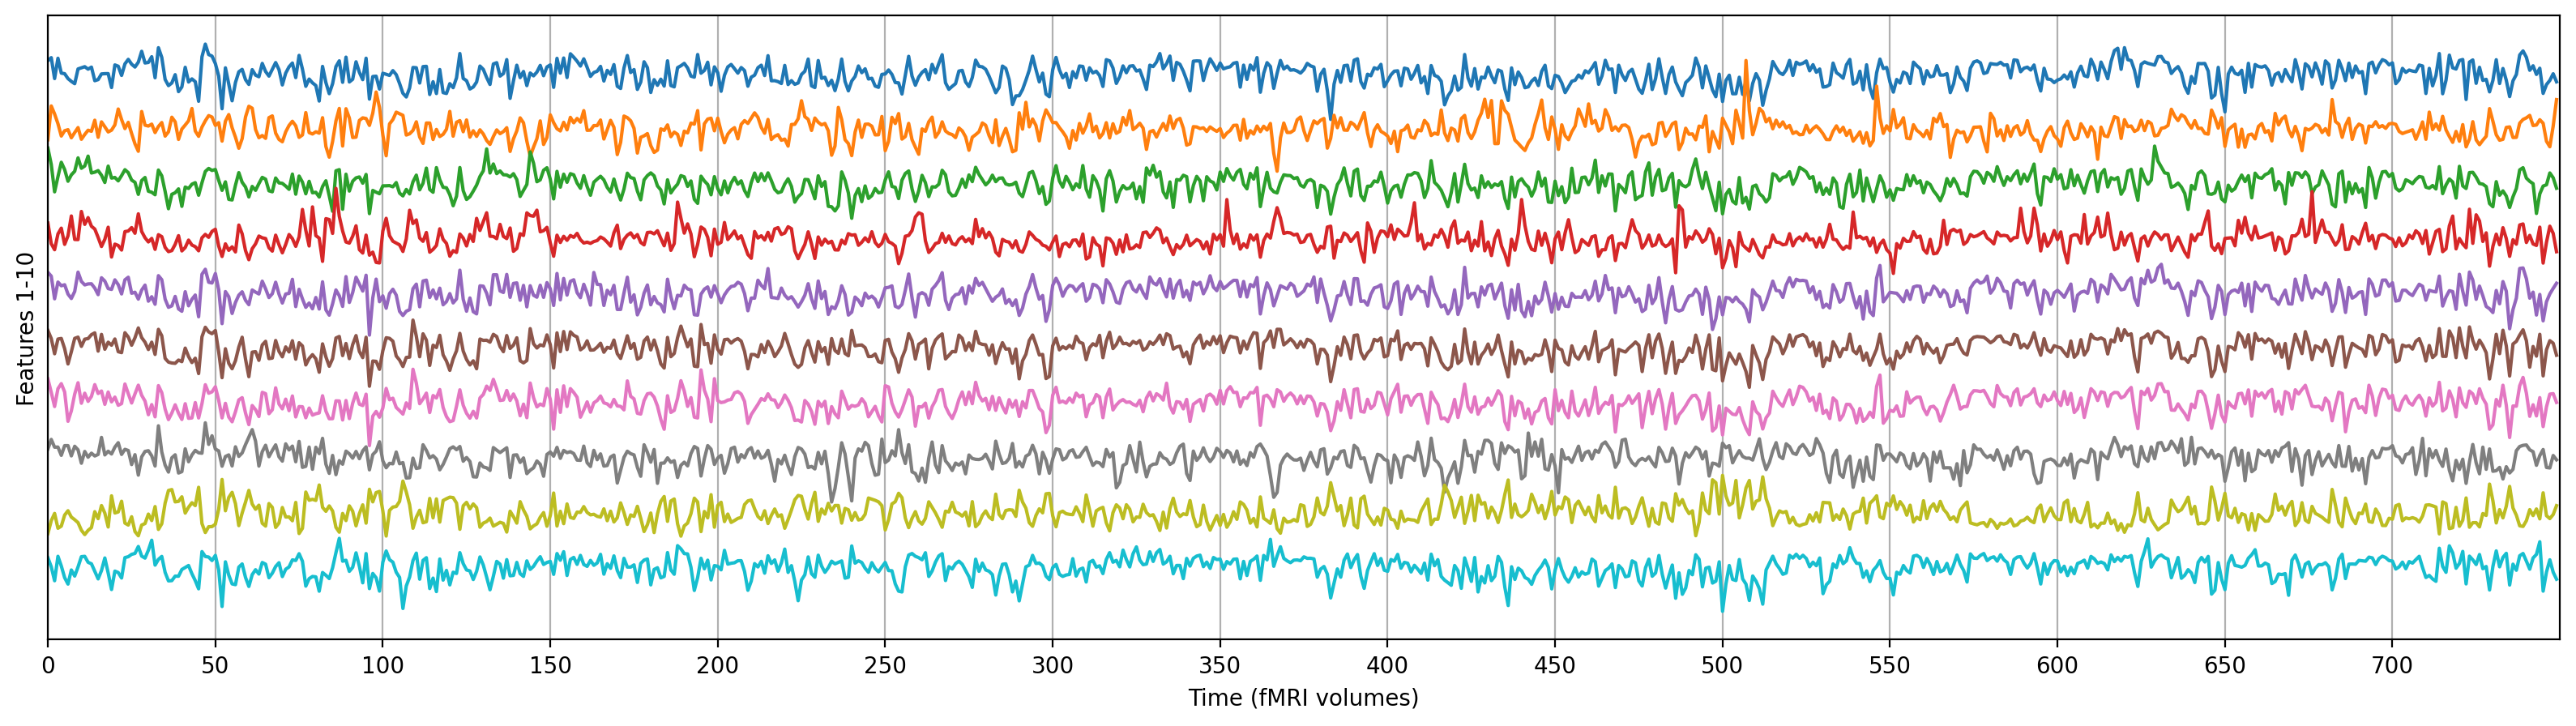

In [370]:
# Plot some of the combined stimuli
f = figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(Rstim[:750,ii] - 5 * ii)

ax.set_xlim(0, 750)
ax.set_yticks([])
ax.set_xticks(range(0, 750, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

### Concatenate delayed stimuli for FIR model
Next we concatenate multiple delayed versions of the stimuli, in order to create a linear [finite impulse response (FIR) model](http://en.wikipedia.org/wiki/Fir_filter). 

#### Background: the hemodynamic response
fMRI measures the blood-oxygen level dependent (BOLD) signal, which is a complicated and nonlinear combination of blood oxygenation and blood volume. When neurons in an area of the brain become active, they start using up lots of energy. To compensate, nearby blood vessels dilate so that more oxygen and glucose become available to the neurons. The resulting changes in blood oxygenation (which increases) and volume (which also increases) create the magnetic signature that is recorded by fMRI. 

But this process is **slow**. It takes seconds after the neural activity begins for the blood vessels to dilate and for the BOLD response to become apparent. And then it takes more seconds for the response to go away. So although a neural response might only last milliseconds, the associated BOLD response will rise and fall over a span of maybe 10 seconds, orders of magnitude slower. The shape of this rise and fall is called the [hemodynamic response function (HRF)](http://en.wikipedia.org/wiki/Haemodynamic_response).

Here is a pretty standard looking example of an HRF:

<img src='http://www.brainmatters.nl/wp-content/uploads/bold.png' width=350px></img>

#### FIR model
To accurately model how the brain responds to these stimuli we must also model the HRF. We have used a separate HRF for each semantic feature in each voxel that is being modeled. This estimate is going to take the form of a linear finite impulse response (FIR) model. To build a linear FIR model we have to concatenate together multiple delayed copies of the stimulus. We have used four delays: 1, 2, 3, and 4 time points. The resulting delayed features can be thought of as representing the stimulus 1, 2, 3, and 4 time points ago. So the regression weights for those features will represent how a particular voxel responds to a feature 1, 2, 3, or 4 time points in the past, and these regression weights are a 4-point estimate of the HRF for that feature in that voxel.

The potential downside of the FIR model is that it may be too expressive. Each feature in each voxel is allowed to have any HRF, but this comes at the cost of multiplying the total number of regression weights that we must fit by the number of delays. In all likelihood the true HRFs vary, but they don't vary that much, so we probably don't need this many independent features. This cost becomes apparent if we increase the number of delays. This will slow down model fitting and likely decrease the stability of the regression weights, leading to decreased model performance. 

In [371]:
# Delay stimuli
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)


FIR model delays:  range(1, 5)


In [372]:
delCONTEXT_Rstim = []
delCONTEXT_Pstim = []

for context in CONTEXTS:
    delCONTEXT_Rstim.append(make_delayed(CONTEXT_Rstim[context-1], delays))
    delCONTEXT_Pstim.append(make_delayed(CONTEXT_Pstim[context-1], delays))
    

In [373]:
# Print the sizes of these matrices
print ("delRstim shape: ", delRstim.shape)
print ("delPstim shape: ", delPstim.shape)

delRstim shape:  (3737, 3940)
delPstim shape:  (291, 3940)


In [374]:
# print the sizes of the context matrices
print ("delCONTEXT_Rstim shape: ", delCONTEXT_Rstim[0].shape)
print ("delCONTEXT_Pstim shape: ", delCONTEXT_Pstim[0].shape)

delCONTEXT_Rstim shape:  (3737, 3072)
delCONTEXT_Pstim shape:  (291, 3072)


In [379]:
with open('regression_results/layer_12', 'rb') as f:
    results_12 = dict(pickle.load(f))
results_12['delPstim'] = delCONTEXT_Pstim
results_12['delRstim'] = delCONTEXT_Rstim
with open('regression_results/layer_12.p', 'wb') as f:
    pickle.dump(results_12, f)

In [380]:
with open('regression_results/layer_12.p', 'rb') as f:
    results_12 = dict(pickle.load(f))
print(results_12.keys())

dict_keys(['wt', 'corr', 'alphas', 'bscorrs', 'valinds', 'delPstim', 'delRstim'])


### Visualizing FIR features
Here we will visualize the first semantic feature at each of the delays.

#### 1. Baseline Embeddings:

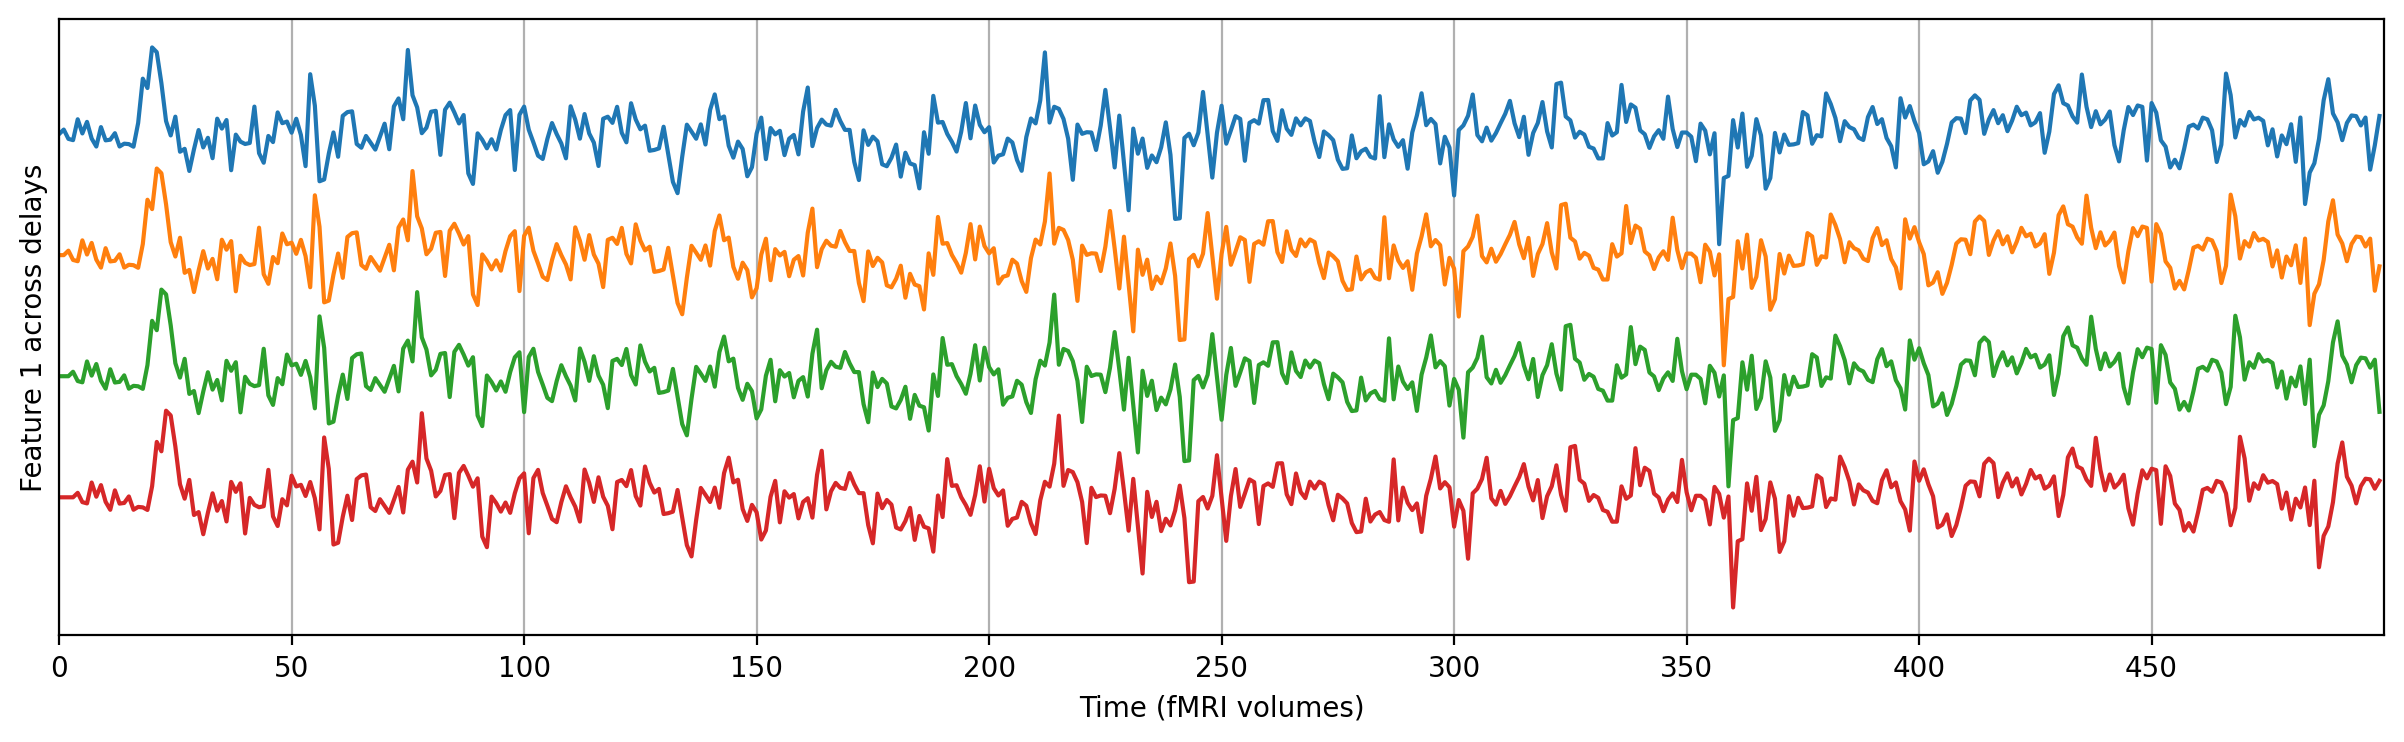

In [ ]:
# Plot the same feature at different delays
f = figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(ndelays):
    ax.plot(delRstim[:500, ii * Rstim.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

#### 2. Contexualized embeddings:

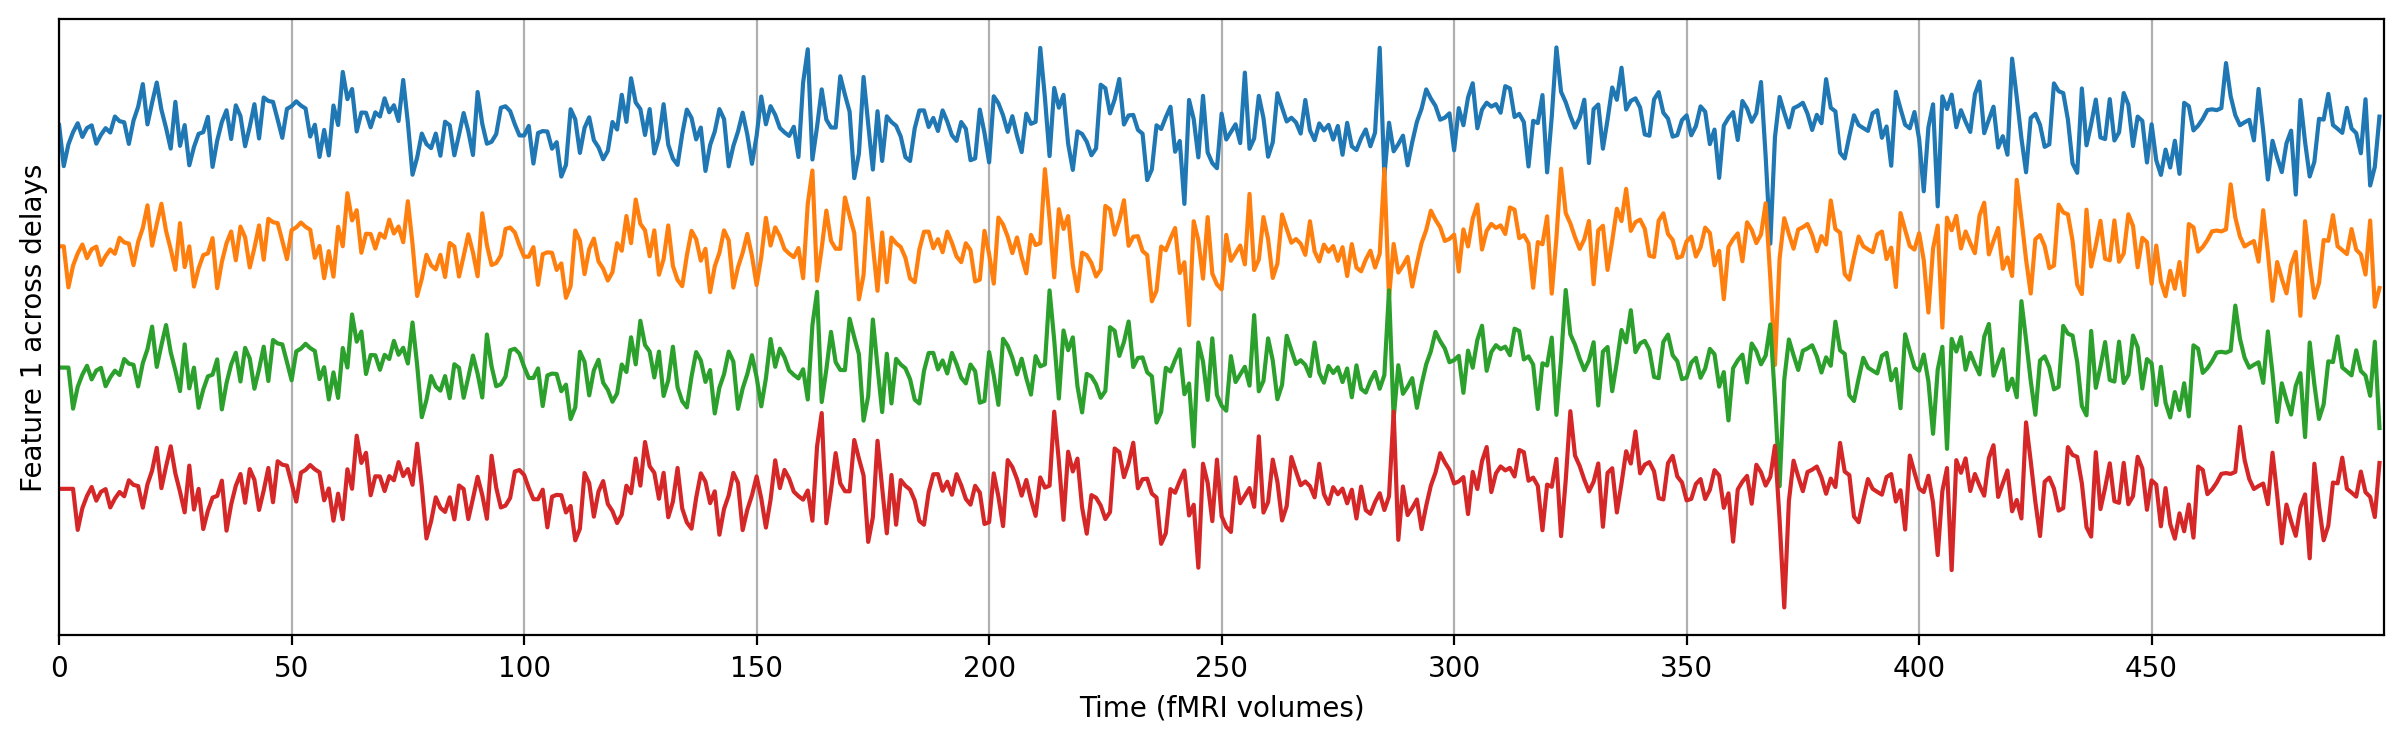

In [ ]:
# Plot the same feature at different delays
f = figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(ndelays):
    ax.plot(delCONTEXT_Rstim[0][:500, ii * CONTEXT_Rstim[0].shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

## Response data
We load the fMRI data that is stored as preprocessed responses (the 3D images were motion corrected and aligned to each other, detrended, and then z-scored within each stimulus).

- `zRresp`, the responses to the regression dataset
- `zPresp`, the responses to the prediction dataset
- `mask`, which is a 3D mask showing which voxels have been selected 

(we are only modeling the voxels that overlap with the **cerebral cortex**).

In [ ]:
# Load responses
import tables
resptf = tables.open_file("data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [ ]:
# Print matrix shapes
print ("zRresp shape (num time points, num voxels): ", zRresp.shape)
print ("zPresp shape (num time points, num voxels): ", zPresp.shape)
print ("mask shape (Z, Y, X): ", mask.shape)

zRresp shape (num time points, num voxels):  (3737, 37226)
zPresp shape (num time points, num voxels):  (291, 37226)
mask shape (Z, Y, X):  (31, 100, 100)


### Visualize where the voxels are coming from (mask)
We plot a single slice along z-axis called an "axial" slice.

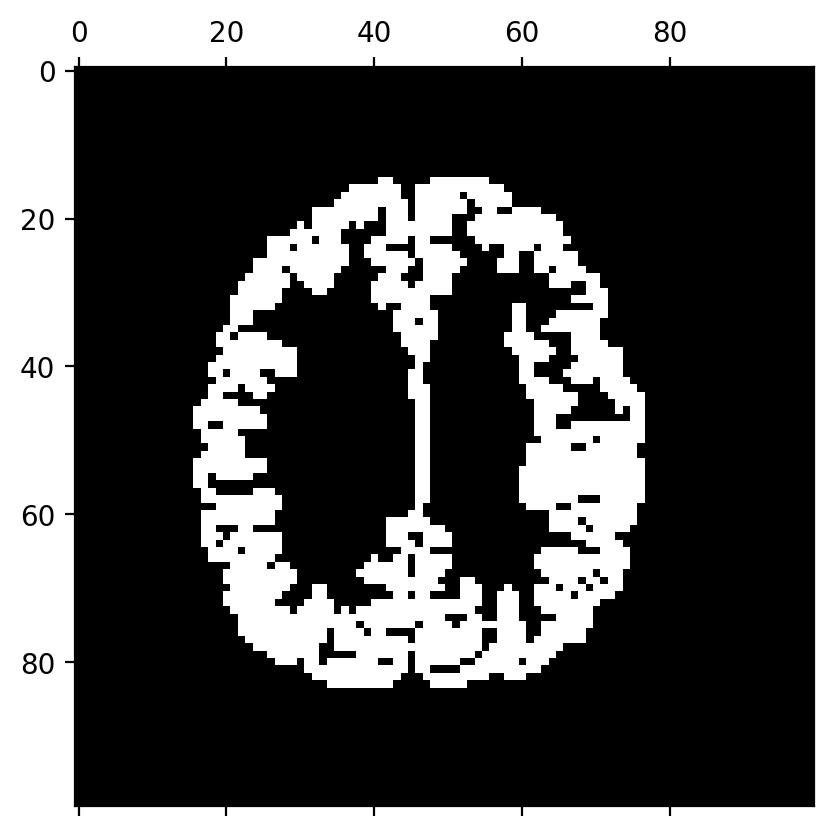

In [ ]:
# Plot one slice of the mask that was used to select the voxels
f = figure()
ax = f.add_subplot(1,1,1)
ax.matshow(mask[16], interpolation="nearest", cmap=cm.gray) # show the 17th slice of the mask

### Visualizing the responses of a few voxels over time
Next yoweu will visualize the responses of a few selected voxels over time. We selected these particular voxels because they are reasonably well explained by the semantic model, but have some differences in their responses across time.

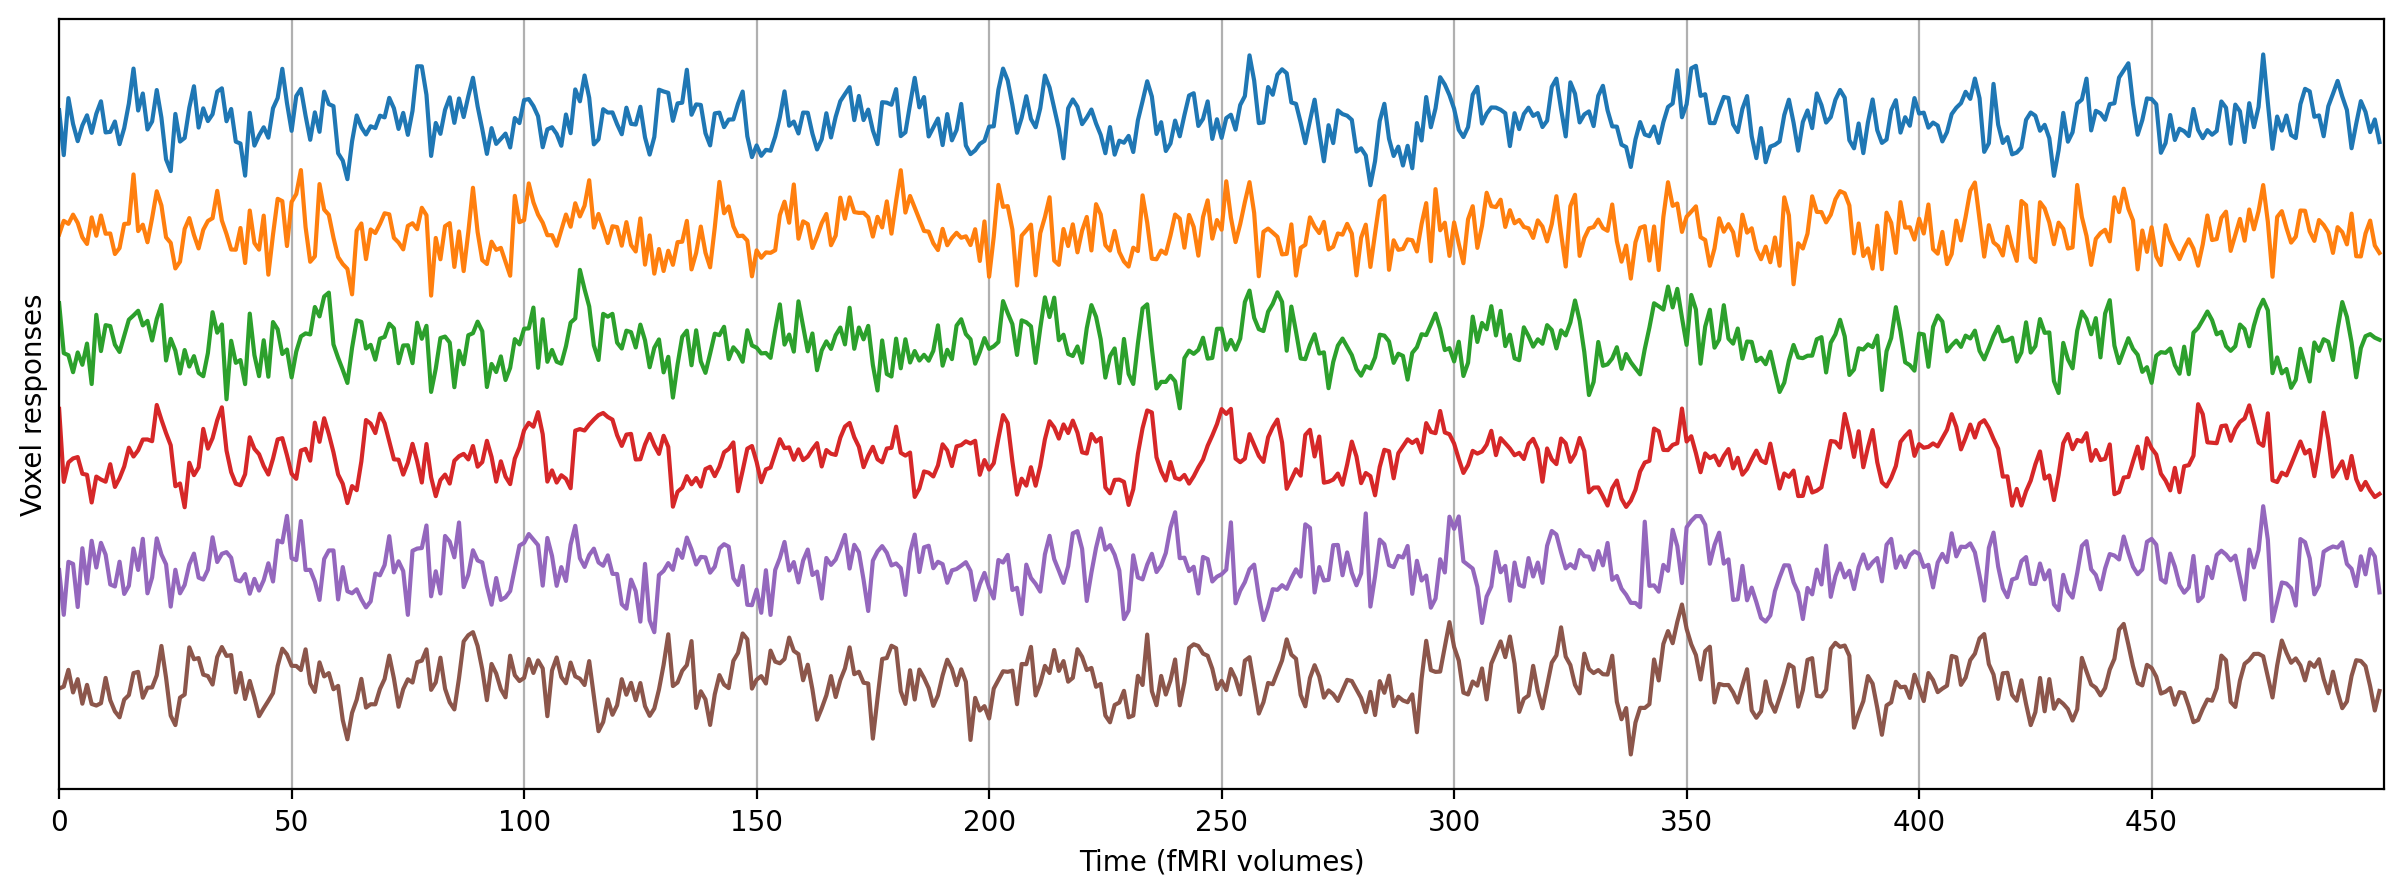

In [ ]:
# Plot the response of a few voxels over time
selvoxels = [20710, 27627, 24344, 34808, 22423, 25397]

f = figure(figsize=(15, 5))
ax = f.add_subplot(1,1,1)
for ii,vi in enumerate(selvoxels):
    ax.plot(zRresp[:500, vi] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Voxel responses")
ax.grid()

## Regression model
Finally, the core of the analysis: we will fit a regression model that predicts the responses of each voxel as a weighted sum of the semantic features. This model will then be tested using a held out dataset (the Prediction dataset). 
This is a linear regression model, so if the response time course for voxel $j$ is $R_j$, the stimulus time course for semantic feature $i$ is $S_i$, and the regression weight for feature $i$ in voxel $j$ is $\beta_{ij}$, then the model can be written as:

$$\hat{R}_j = \beta_{0j} S_0 + \beta_{1j} S_1 + \cdots$$

or:

$$\hat{R}_j = \sum_i \beta_{ij} S_i$$

The  estimation of the $\beta_j$ values is commonly done by minimizing the sum of the squared error (here across time, $t$):

$$E_j(\beta) = \sum_t (R_{jt} - \hat{R}_{jt})^2 = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2$$

$$\beta_j = \underset{\beta}{\operatorname{argmin}} E_j(\beta)$$

The regression used here is **ridge regression**, and is a special case of [Tikhonov regularization](http://en.wikipedia.org/wiki/Ridge_regression). It finds the $\beta$ that minimizes the following error function:

$$E_j(\beta) = \sum_t (R_{jt} - \sum_i \beta_{i} S_{it})^2 + \alpha \sum_i \beta_i^2$$

### The hyperparameter: $\alpha$
$\alpha$controls the strength of the regularization. 

To determine an optimal $\alpha$ we use cross-validation. First, we split the Regression dataset up into two parts. Then we estimate the weights for a given $\alpha$ on the first part, and test how well we can predict responses on the second part. This is repeated for each possible $\alpha$ that we want to test, and for a couple different splits of the Regression dataset. Then we find the $\alpha^*$ that gave us the best predictions within the split Regression dataset. Finally we estimate the weights using the entire Regression dataset and the selected $\alpha^*$.

All of this is encapsulated within the function `bootstrap_ridge`. 

To do cross-validation, `bootstrap_ridge` divides the Regression dataset into many small chunks, and then splits those chunks into the two groups that will be used to estimate weights and test $\alpha$ values. This is better than just choosing individual time points because both the fMRI data and stimuli are autocorrelated (i.e. correlated across time). The parameter `chunklen` determines the length of the chunks, and the parameter `nchunks` determines the number of chunks in the $\alpha$-testing dataset. 

In [ ]:
# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 1 tiny singular values.. (U is now (2937, 2936))
INFO:ridge_corr:Training stimulus has Frobenius norm: 824.370
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02874, max corr=0.23945, over-under(0.20)=38
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03505, max corr=0.27851, over-under(0.20)=124
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.04100, max corr=0.31493, over-under(0.20)=316
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.04642, max corr=0.34607, over-under(0.20)=620
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.05135, max corr=0.38280, over-under(0.20)=984
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.05585, max corr=0.40470, over-under(0.20)=1396
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.05950, max corr=0.41214, over-under(0.20)=1620
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.06073, max corr=0.40833, over-under(0.20)=1556
I

In [ ]:
ALPHA = alphas[0]

In [ ]:
# Run regression

wtCONTEXT = [0]*20
corrCONTEXT = [0]*20
alphasCONTEXT = [0]*20
bscorrsCONTEXT = [0]*20
valindsCONTEXT = [0]*20
for context in CONTEXTS:
    wtCONTEXT[context-1], corrCONTEXT[context-1], alphasCONTEXT[context-1], bscorrsCONTEXT[context-1], valindsCONTEXT[context-1] = bootstrap_ridge(delCONTEXT_Rstim[context-1], zRresp, delCONTEXT_Pstim[context-1], zPresp,
                                                     [ALPHA], nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 1 tiny singular values.. (U is now (2937, 2936))
INFO:ridge_corr:Training stimulus has Frobenius norm: 1116.971
INFO:ridge_corr:Training: alpha=215.000, mean corr=0.03988, max corr=0.45581, over-under(0.20)=1031
INFO:counter:1/1 items complete (33.85 seconds/item, 00:00:00 remaining)
INFO:ridge_corr:Total training stimulus has Frobenius norm: 1262.686
INFO:ridge_corr:Finding single best alpha..
INFO:ridge_corr:Best alpha = 215.000
INFO:ridge_corr:Computing weights for each response using entire training set..
INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 1 tiny singular values.. (U is now (2937, 2936))
INFO:ridge_corr:Training stimulus has Frobenius norm: 962.051
INFO:ridge_corr:Training: alpha=215.000, mean corr=0.05230, max corr=0.39806, over-under(0.20)=933
INFO:counter:1/1 items complete (42.09 seconds/item, 00:00:00 remaining)
INFO

In [ ]:
#store all regression results in a dictionary and pickle it
regression_results = {}
regression_results['wt'] = wt
regression_results['corr'] = corr
regression_results['alphas'] = alphas
regression_results['bscorrs'] = bscorrs
regression_results['valinds'] = valinds
regression_results['pred'] = np.dot(delPstim, wt)

with open('regresion_results/embeddings', 'wb') as f:
    pickle.dump(regression_results, f)

In [ ]:
with open('regresion_results/embeddings', 'rb') as f:
    regression_results = pickle.load(f)
print(regression_results.keys())

dict_keys(['wt', 'corr', 'alphas', 'bscorrs', 'valinds', 'delRstim', 'delPstim'])


In [ ]:
#store all regression results in a dictionary and pickle it
regression_results_12 = {}
regression_results_12['wt'] = wtCONTEXT
regression_results_12['corr'] = corrCONTEXT
regression_results_12['alphas'] = alphasCONTEXT
regression_results_12['bscorrs'] = bscorrsCONTEXT
regression_results_12['valinds'] = valindsCONTEXT
regression_results_12['pred'] = [np.dot(delCONTEXT_Pstim[context - 1], wtCONTEXT[context - 1]) for context in CONTEXTS]

with open('regresion_results/layer_12', 'wb') as f:
    pickle.dump(regression_results_12, f)

DEBUG:matplotlib.ticker:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG:matplotlib.ticker:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
DEBUG:matplotlib.ticker:vmin 7.943282347242816 vmax 1258.9254117941675
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
DEBUG:matplotlib.ticker:vmin 7.943282347242816 vmax 1258.92541

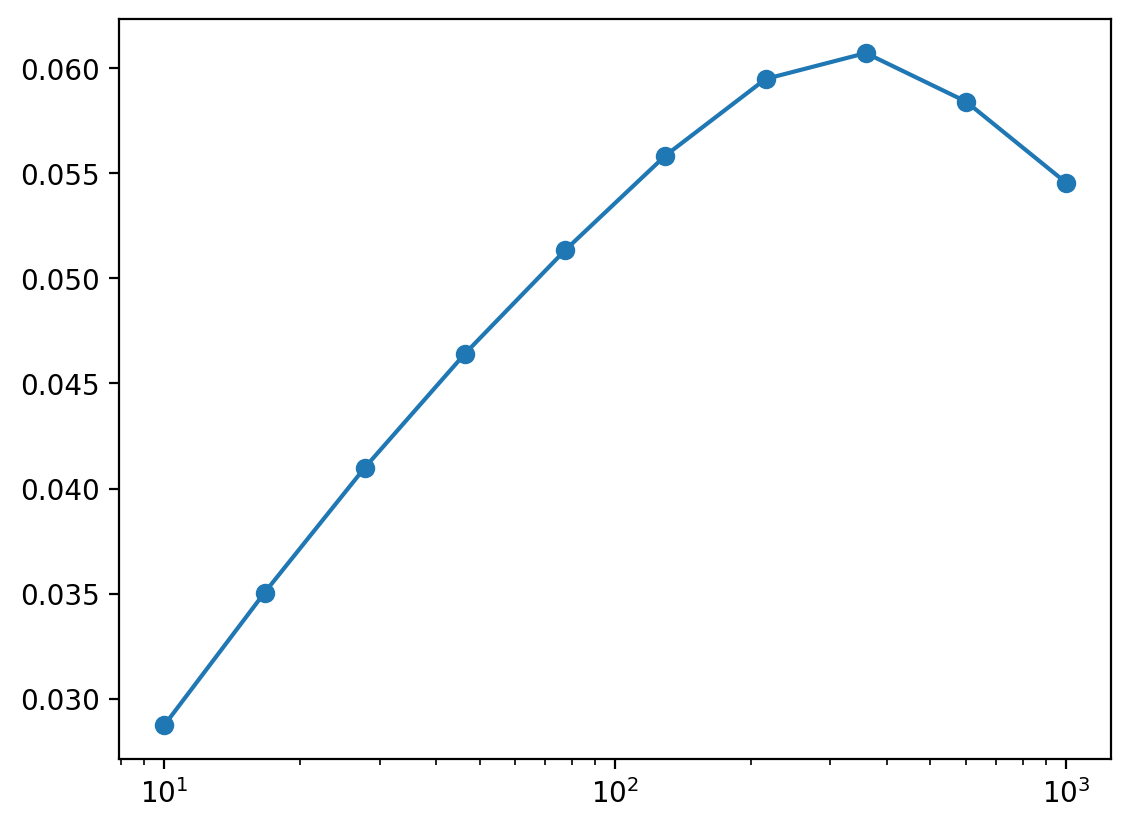

In [ ]:
f = figure()
ax = f.add_subplot(1,1,1)
ax.semilogx( np.logspace(1, 3, 10), bscorrs.mean(2).mean(1), 'o-')

In [ ]:
# print(alphasCONTEXT)
# f = figure()
# ax = f.add_subplot(1,1,1)
# ax.semilogx( np.logspace(1, 3, 10), bscorrsCONTEXT[0].mean(2).mean(1), 'o-')

### Variables returned by the regression
Next let's have a look at the variables returned by the regression function.

In [ ]:
# wt is the regression weights
print ("wt has shape: ", wt.shape)

# corr is the correlation between predicted and actual voxel responses in the Prediction dataset
print ("corr has shape: ", corr.shape)

# alphas is the selected alpha value for each voxel, here it should be the same across voxels
print ("alphas has shape: ", alphas.shape)

# bscorrs is the correlation between predicted and actual voxel responses for each round of cross-validation
# within the Regression dataset
print ("bscorrs has shape (num alphas, num voxels, nboots): ", bscorrs.shape)

# valinds is the indices of the time points in the Regression dataset that were used for each
# round of cross-validation
print ("valinds has shape: ", np.array(valinds).shape)

wt has shape:  (3072, 37226)
corr has shape:  (37226,)
alphas has shape:  (37226,)
bscorrs has shape (num alphas, num voxels, nboots):  (10, 37226, 1)
valinds has shape:  (1, 800)


In [ ]:
# wt is the regression weights
print ("wt has shape: ", wtCONTEXT[0].shape)

# corr is the correlation between predicted and actual voxel responses in the Prediction dataset
print ("corr has shape: ", corrCONTEXT[0].shape)

# alphas is the selected alpha value for each voxel, here it should be the same across voxels
print ("alphas has shape: ", alphasCONTEXT[0].shape)

# bscorrs is the correlation between predicted and actual voxel responses for each round of cross-validation
# within the Regression dataset
print ("bscorrs has shape (num alphas, num voxels, nboots): ", bscorrsCONTEXT[0].shape)

# valinds is the indices of the time points in the Regression dataset that were used for each
# round of cross-validation
print ("valinds has shape: ", np.array(valindsCONTEXT[0]).shape)

wt has shape:  (3072, 37226)
corr has shape:  (37226,)
alphas has shape:  (37226,)
bscorrs has shape (num alphas, num voxels, nboots):  (1, 37226, 1)
valinds has shape:  (1, 800)


### Testing the regression models by predicting responses
$$\hat{R} = S \beta$$

In [ ]:
# Predict responses in the Prediction dataset
print ("zPresp has shape: ", zPresp.shape)
print ("wt has shape: ", wt.shape)
print ("delPstim has shape: ", delPstim.shape)

zPresp has shape:  (291, 37226)
wt has shape:  (3072, 37226)
delPstim has shape:  (291, 3072)


In [ ]:
pred = np.dot(delPstim, wt)

print ("pred has shape: ", pred.shape)

pred has shape:  (291, 37226)


In [ ]:
predCONTEXT = [np.dot(delCONTEXT_Pstim[context - 1], wtCONTEXT[context - 1]) for context in CONTEXTS]

print ("pred has shape: ", predCONTEXT[0].shape)

pred has shape:  (291, 37226)


#### Visualizing predicted and actual responses
Next let's plot some predicted and actual responses side by side.

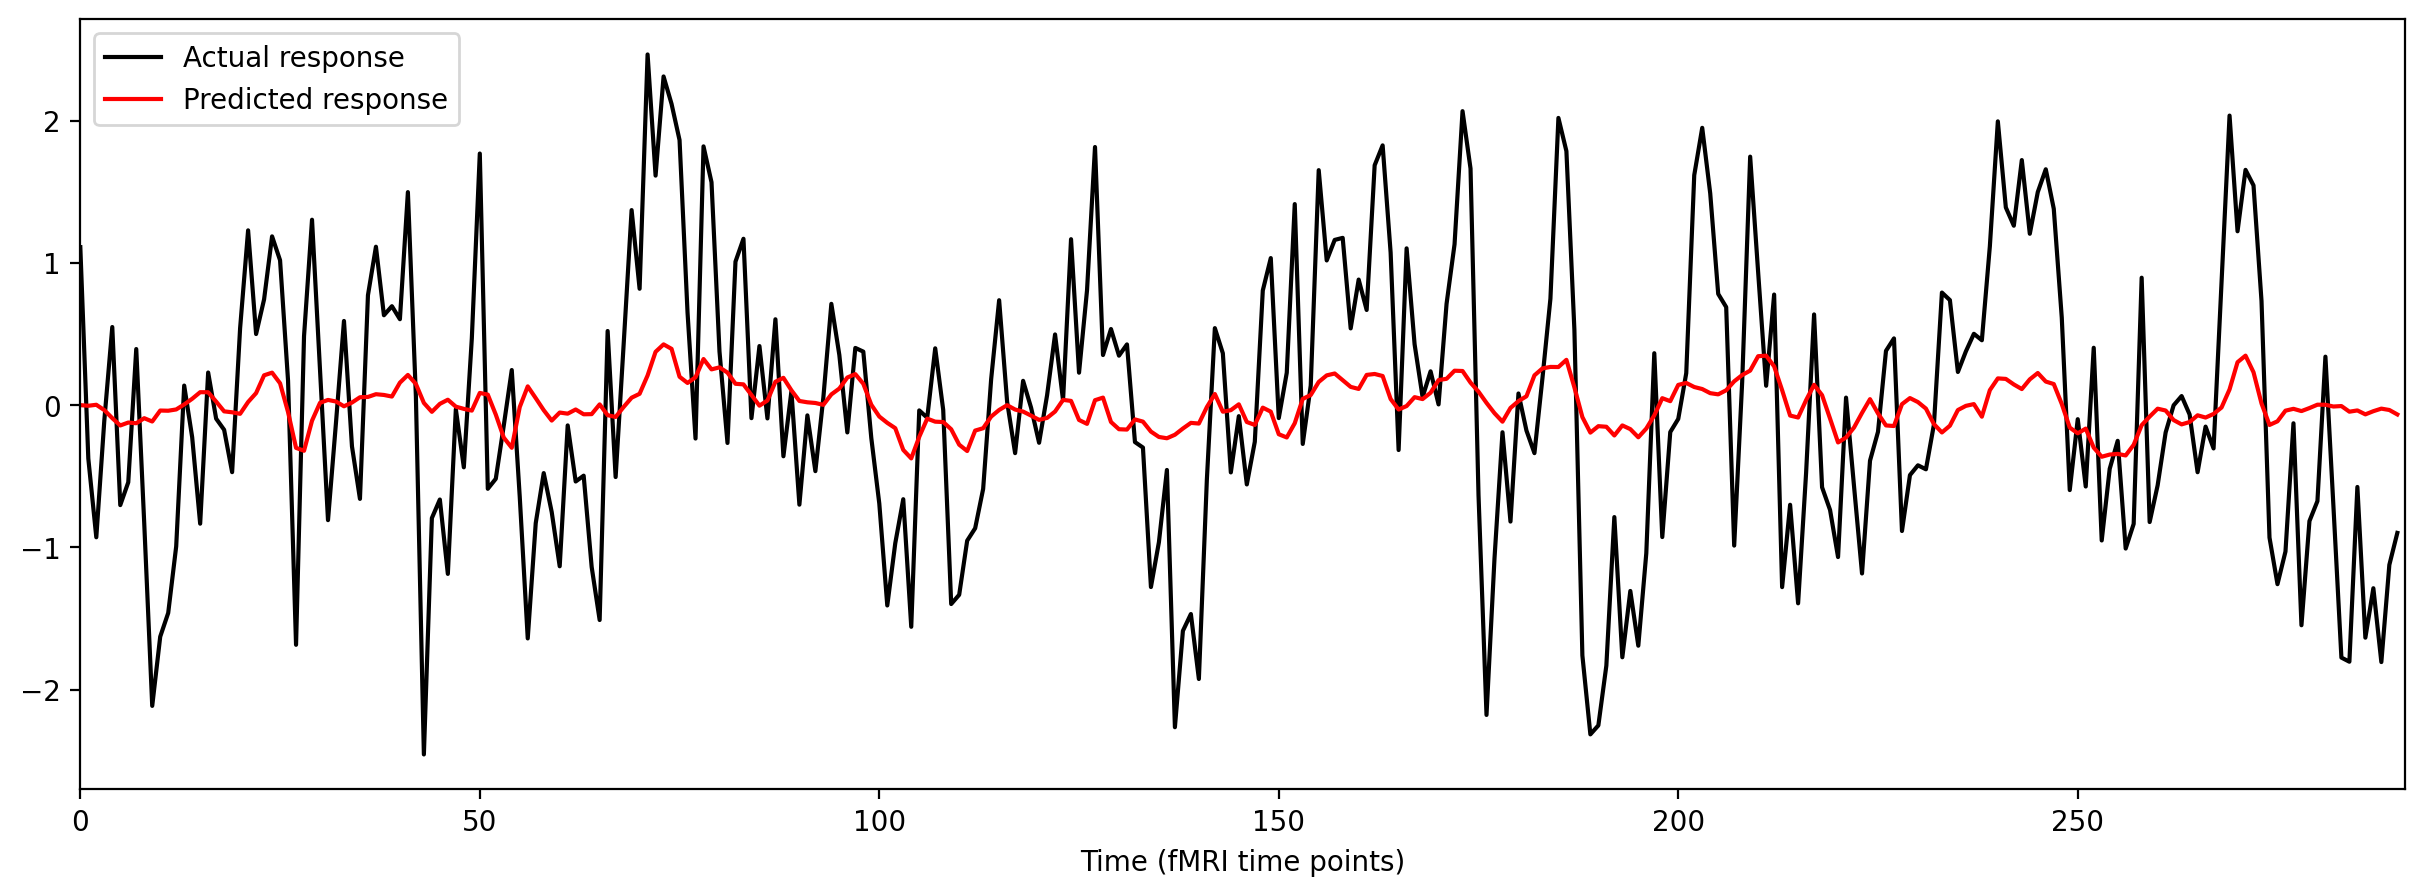

In [ ]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a decent voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(pred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"));

#### Visualizing predicted and actual responses cont'd
Since the predicted and actual responses look pretty different scale-wise, we rescale them both to have unit standard deviation and re-plot.

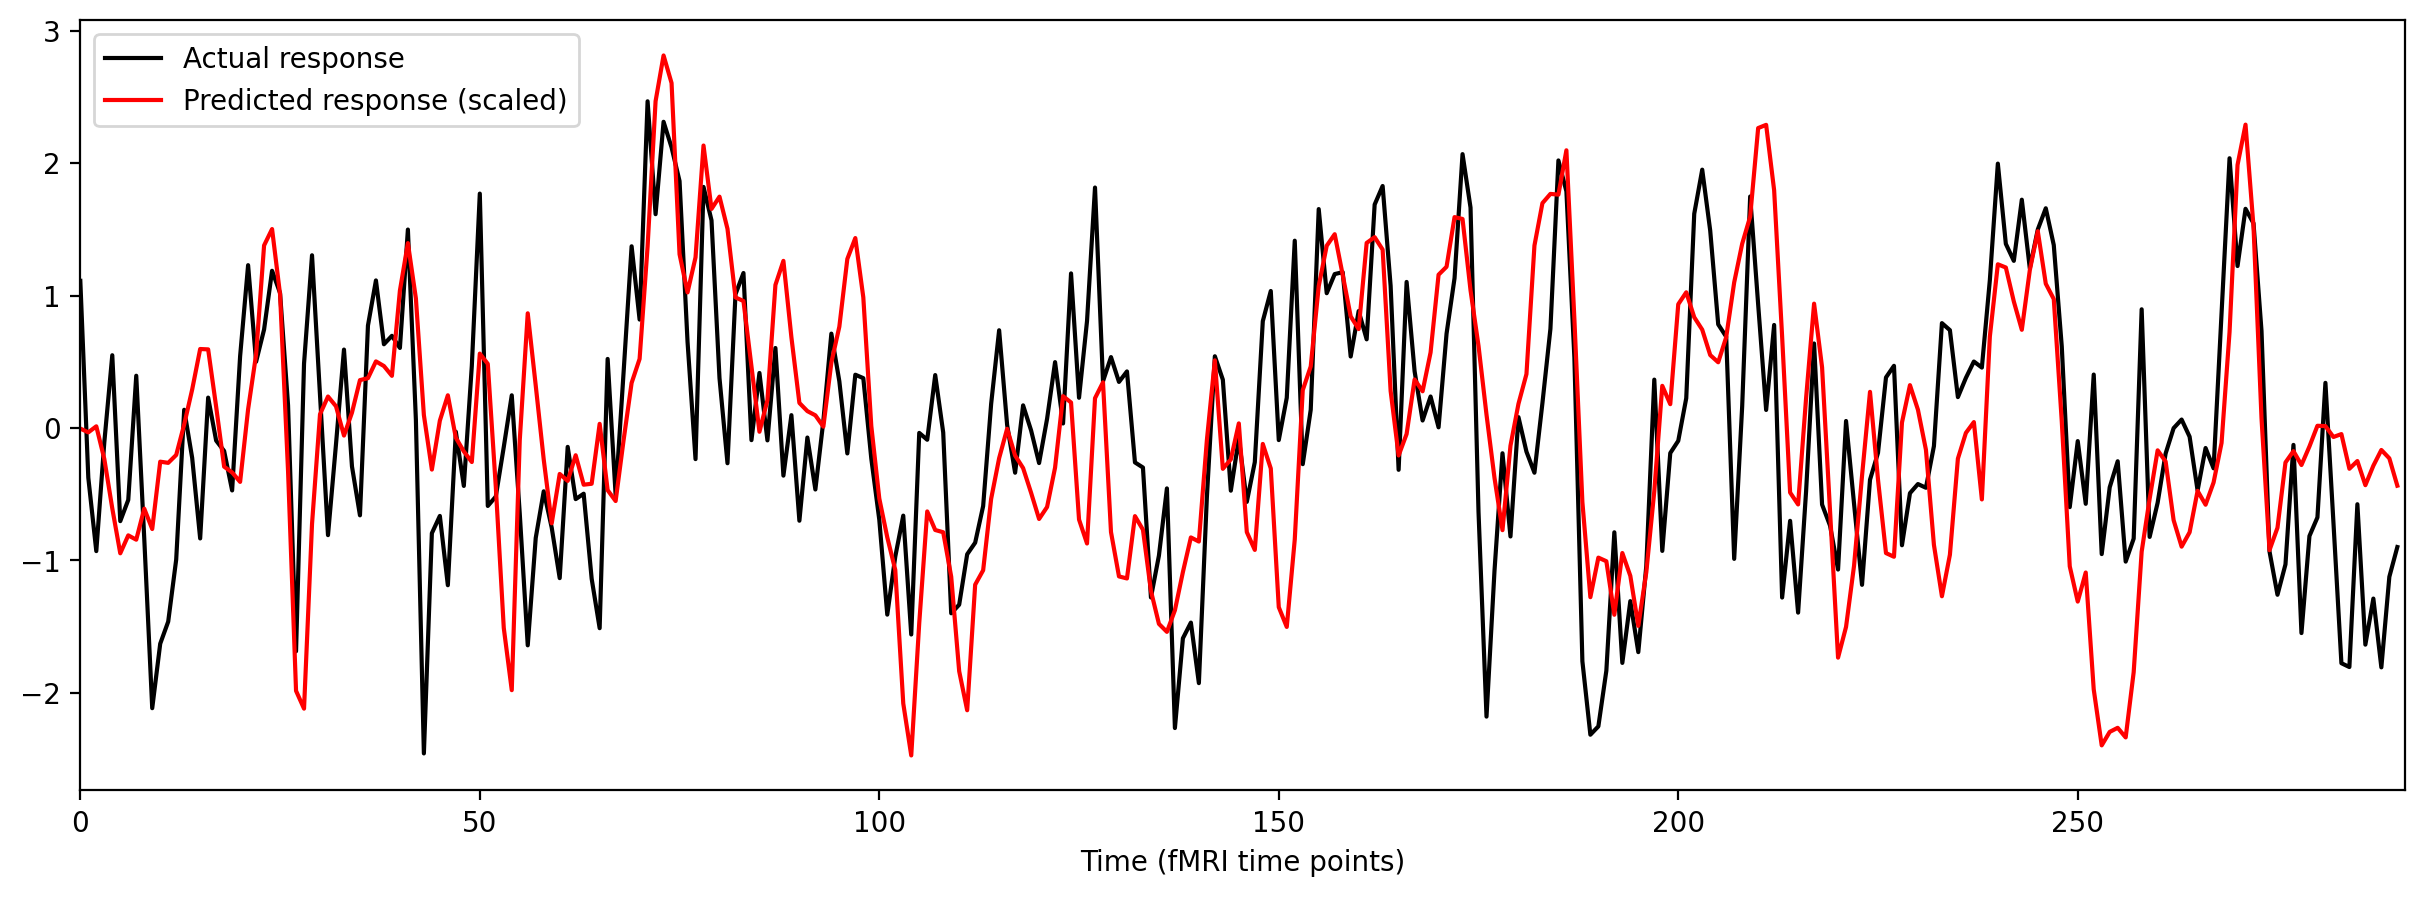

In [ ]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

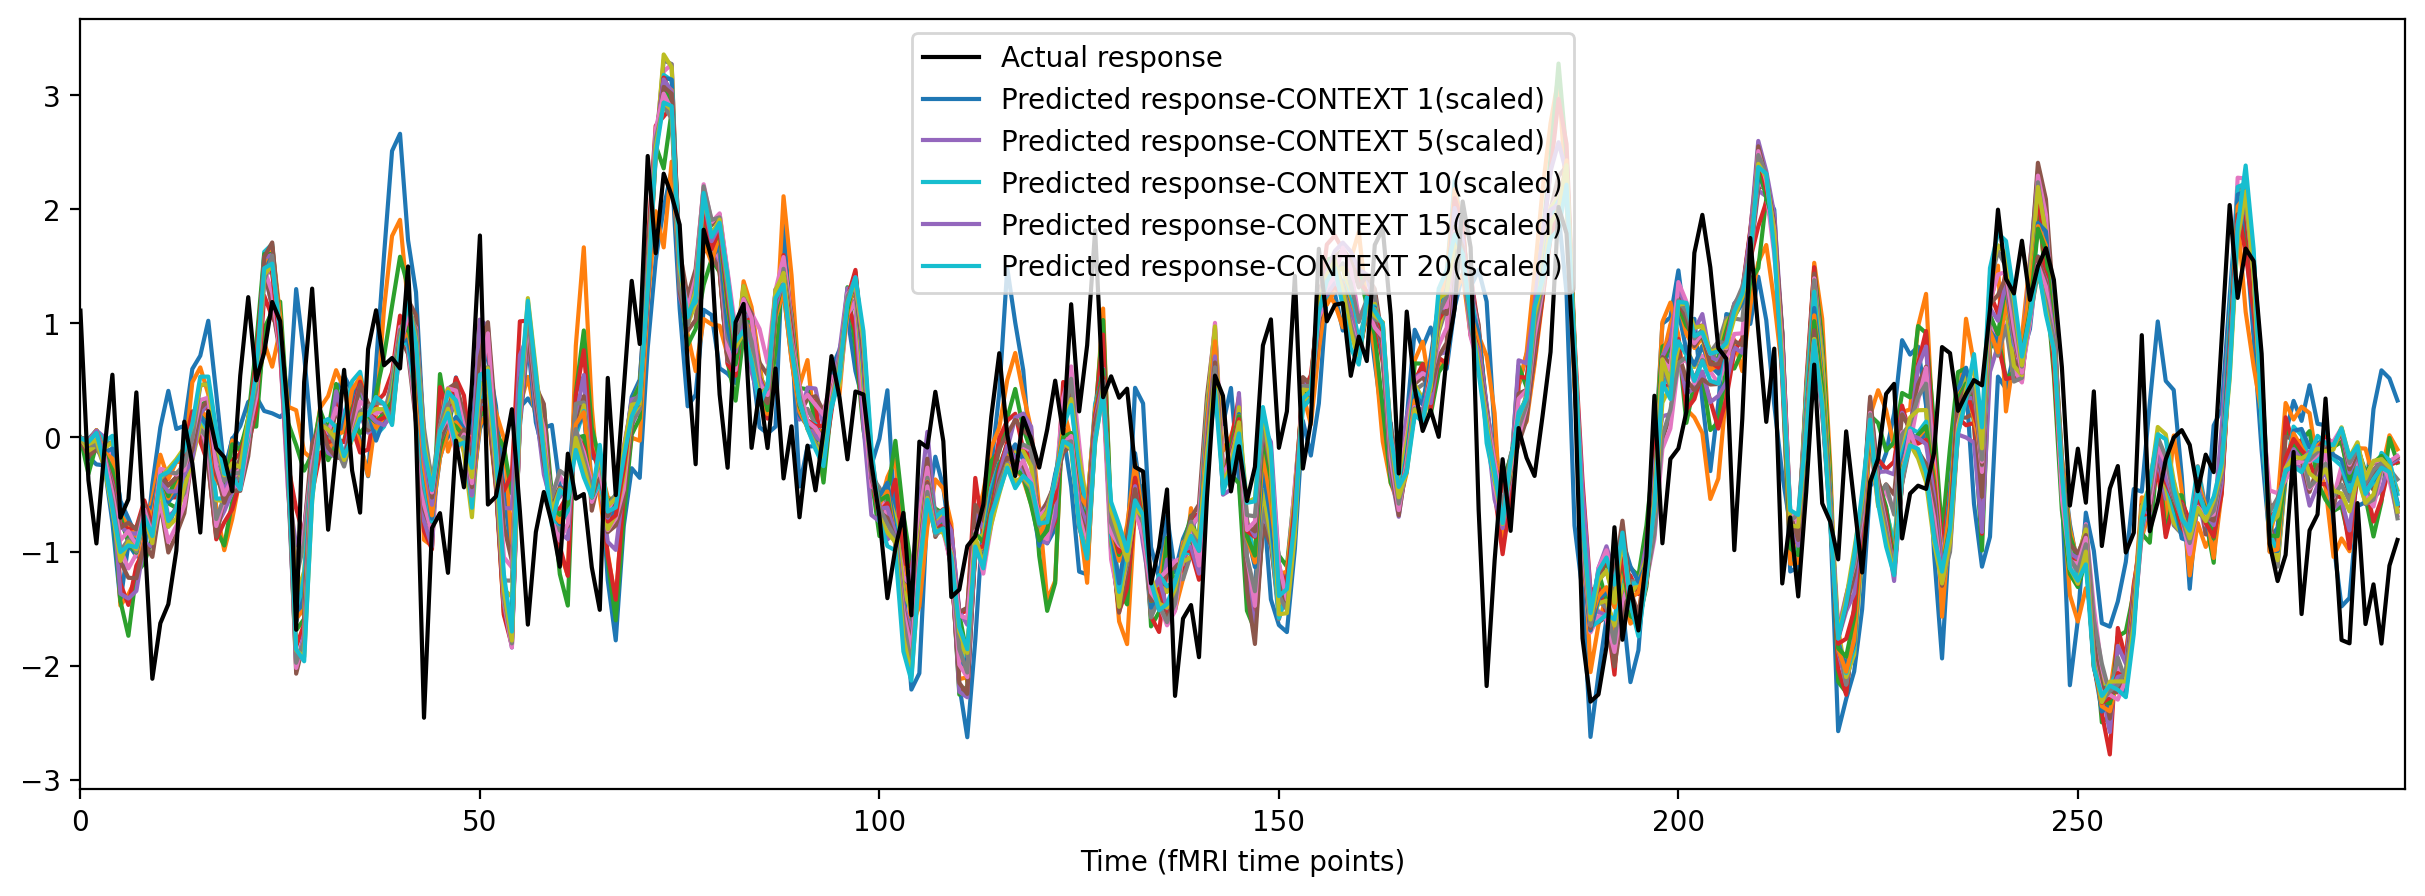

In [ ]:
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

predresp = [ax.plot(zscore(predCONTEXT[context-1][:,selvox]), label=str(context))[0] for context in CONTEXTS]
realresp = ax.plot(zPresp[:,selvox], 'k')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp[0], predresp[4], predresp[9], predresp[14], predresp[19]), ("Actual response", "Predicted response-CONTEXT 1(scaled)", "Predicted response-CONTEXT 5(scaled)", "Predicted response-CONTEXT 10(scaled)", "Predicted response-CONTEXT 15(scaled)", "Predicted response-CONTEXT 20(scaled)"));

Now we can quantify this similarity by computing the correlation between the two.

#### 1. wordToVec embeddings:

In [ ]:
# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorr = np.corrcoef(zPresp[:,selvox], pred[:,selvox])[0,1]
print ("Correlation between predicted and actual responses for voxel %d: %f" % (selvox, voxcorr))

Correlation between predicted and actual responses for voxel 20710: 0.570716


#### 2. Contexualized embeddings:

In [ ]:
# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorrCONTEXT = [np.corrcoef(zPresp[:,selvox], predCONTEXT[context -1][:,selvox])[0,1] for context in CONTEXTS]
print ("Correlation between predicted and actual responses for voxel %d: " % (selvox), voxcorrCONTEXT)

Correlation between predicted and actual responses for voxel 20710:  [0.46327933639690555, 0.49987666410102843, 0.5647896185435018, 0.577344228309531, 0.5950819914199491, 0.6001254100205478, 0.6081443628270294, 0.6061137104496525, 0.6070344964248534, 0.6070400135501135, 0.5987580199095148, 0.5997691011679752, 0.5956437745839946, 0.590825578486124, 0.5905212452797909, 0.5896523879355704, 0.5831557931364255, 0.5839048380839695, 0.578889714283433, 0.5860291814254057]


#### Computing correlations for all voxels
Next let's compute this correlation for every voxel in the dataset. There are some very efficient ways to do this, but here I've written a for loop so that it's very explicit what's happening. (This should give exactly the same values as the variable `corr`, which was returned by `bootstrap_ridge`.)

In [ ]:
voxcorrs = np.zeros((zPresp.shape[1],)) # create zero-filled array to hold correlations
voxcorrsCONTEXT = [np.zeros((zPresp.shape[1],)) for context in CONTEXTS] # create zero-filled array to hold correlations
for vi in range(zPresp.shape[1]):
    voxcorrs[vi] = np.corrcoef(zPresp[:,vi], pred[:,vi])[0,1]
    for context in CONTEXTS:
        voxcorrsCONTEXT[context-1][vi] = np.corrcoef(zPresp[:,vi], predCONTEXT[context-1][:,vi])[0,1]
print (voxcorrs)

[ 0.05064817  0.01788456 -0.01548662 ...  0.07615076 -0.04228578
  0.03606779]


In [ ]:
x_axis = np.arange(1, 21)
# get overall model performance
y_axis = np.ones(20)*np.mean(voxcorrs)
y_axisCONTEXT = [np.mean(voxcorrsCONTEXT[context-1])*10 for context in CONTEXTS]

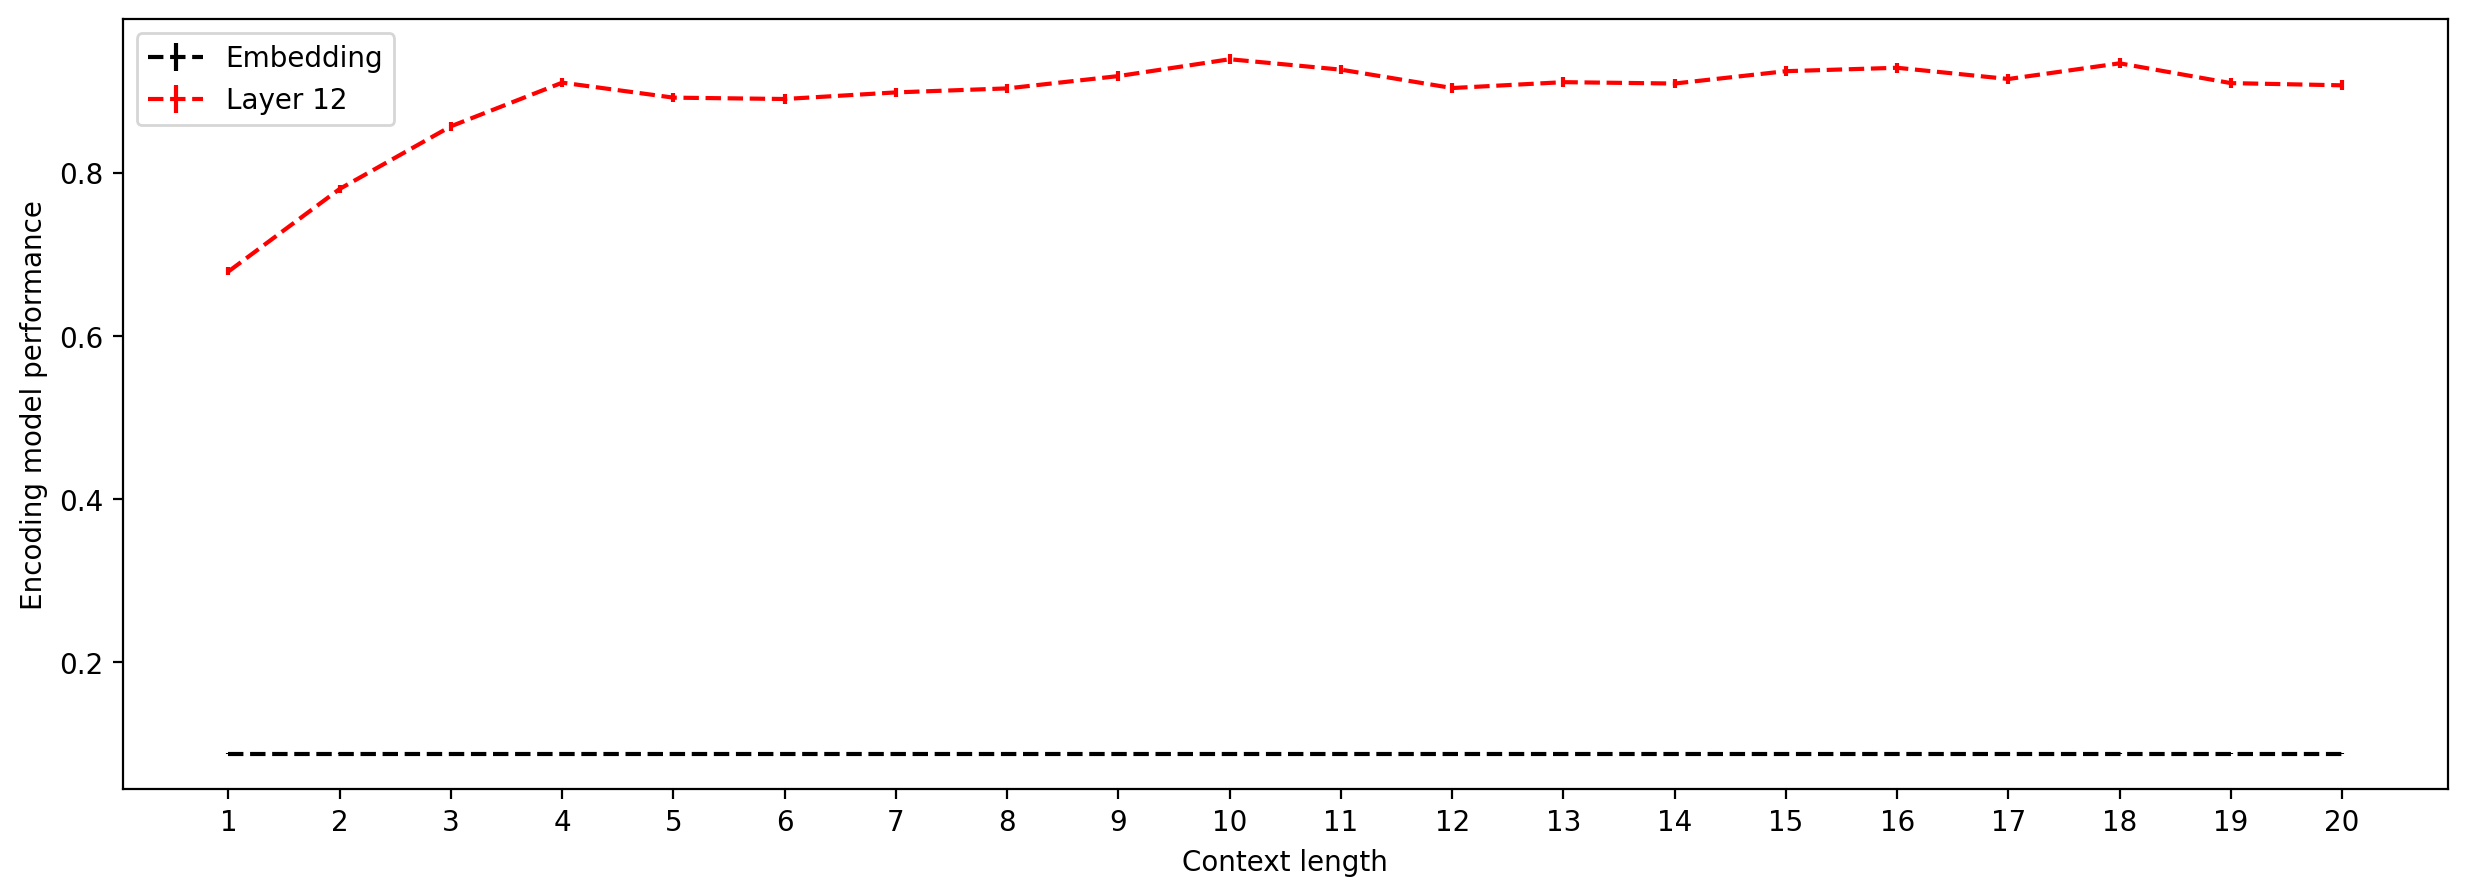

In [ ]:
# get adjusted standard error
e_axis = np.ones(20)*(np.std(voxcorrs) / np.sqrt(len(voxcorrs)))
e_axisCONTEXT = [(np.std(voxcorrsCONTEXT[context-1]) / np.sqrt(len(voxcorrsCONTEXT[context-1])))*10 for context in CONTEXTS]
# plot model performance
f = figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

ax.set_xticks(x_axis)
ax.set_xlabel("Context length")
ax.set_ylabel("Encoding model performance")
basic = ax.errorbar(x_axis, y_axis, e_axis, color='black', linestyle='--',label = 'Embedding')
layer12 = ax.errorbar(x_axis, y_axisCONTEXT, e_axisCONTEXT, color='red', linestyle='--',label = 'Layer 12')

ax.legend()